In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import plotly
import plotly.io as pio
pio.renderers.default = 'iframe'
import plotly.express as px
plotly.offline.init_notebook_mode(connected=True)
import seaborn as sns
import matplotlib as mpl
import re
import pandas as pd
import json
import os
import sys
import glob

In [2]:
import pandas as pd
import json
import os
import csv
from tqdm import tqdm

data = {}
name = {}
file_path = ''
paths = glob.glob(f'_trial_*{file_path}*')
#paths = glob.glob(f'_trial_*')
for path in tqdm(paths):
    agent = path.split("_")[-6]
    exploration_strategy = path.split("_")[-5]
    grid = path.split("_")[-4]
    bar = "_".join(path.split("_")[-3:-1])
    noise = path.split("_")[-1]
    pkl_files = glob.glob(os.path.join(path, 'saved_agent*.pkl'))
    for file in pkl_files:
        if "learnability" in path:
            otherbar = bar
            othernoise = noise
        else:
            repeat_grid = file.split("_")[3]
            path_file = f"_{repeat_grid}" + re.findall(r'-test.*?_end', file)[0]
            path_file = path_file.replace("'","\"").replace(" ", "").replace("-train","").replace("-test","").replace("_end", "")
            otherbar = "_".join(path_file.split("_")[2:4])
            othernoise = path_file.split("_")[4]
        if agent not in data:
            data[agent] = {}
            name[agent] = {}
        if exploration_strategy not in data[agent]:
            data[agent][exploration_strategy] = {}
            name[agent][exploration_strategy] = {}
        if grid not in data[agent][exploration_strategy]:
            data[agent][exploration_strategy][grid] = {}
            name[agent][exploration_strategy][grid] = {}
        if bar not in data[agent][exploration_strategy][grid]:
            data[agent][exploration_strategy][grid][bar] = {}
            name[agent][exploration_strategy][grid][bar] = {}
        if noise not in data[agent][exploration_strategy][grid][bar]:
            data[agent][exploration_strategy][grid][bar][noise] = {}
            name[agent][exploration_strategy][grid][bar][noise] = {}
        if otherbar not in data[agent][exploration_strategy][grid][bar][noise]:
            data[agent][exploration_strategy][grid][bar][noise][otherbar] = {}
            name[agent][exploration_strategy][grid][bar][noise][otherbar] = {}
        if othernoise not in data[agent][exploration_strategy][grid][bar][noise][otherbar]:
            name[agent][exploration_strategy][grid][bar][noise][otherbar][othernoise] = []
            data[agent][exploration_strategy][grid][bar][noise][otherbar][othernoise] = {}
            data[agent][exploration_strategy][grid][bar][noise][otherbar][othernoise]["tables"] = []

        values = []
        with open(file, newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter='\n', quotechar='|')
            for row in reader:
                values.append(float(row[0]))
        data[agent][exploration_strategy][grid][bar][noise][otherbar][othernoise]["values"] = values

    json_files = glob.glob(os.path.join(path, '*epoch.json'))
    for file in json_files:
        with open(file) as f:
            train_epoch = file.split("-")[-1].replace(rf"train0_","").replace(".json","")
            data[agent][exploration_strategy][grid][bar][noise][otherbar][othernoise]["tables"].append(json.load(f))
            name[agent][exploration_strategy][grid][bar][noise][otherbar][othernoise].append(f'{re.sub("./_trial_", "", path)}_{train_epoch}')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:56<00:00,  1.69it/s]


In [3]:
from matplotlib.colors import LinearSegmentedColormap
import tqdm
import os
import imageio



def generate_occupancy(folder,subfolder,agent, exploration_strategy, somegrid, somebar, somenoise, someotherbar, someothernoise, sortex_idx):
    cmap = mpl.colormaps.get_cmap('binary')  # viridis is the default colormap for imshow

    cmap.set_under(color ='blue')  # Set the color for values below vmin to blue
    cmap.set_over(color ='red')
    cmap.set_bad(color ='green', alpha=0.1)
    states_distribution = {}
    if agent not in states_distribution:
        states_distribution[agent] = {}
    if exploration_strategy not in states_distribution[agent]:
        states_distribution[agent][exploration_strategy] = {}
    if somegrid not in states_distribution[agent][exploration_strategy]:
        states_distribution[agent][exploration_strategy][somegrid] = {}
    if somebar not in states_distribution[agent][exploration_strategy][somegrid]:
        states_distribution[agent][exploration_strategy][somegrid][somebar] = {}
    if somenoise not in states_distribution[agent][exploration_strategy][somegrid][somebar]:
        states_distribution[agent][exploration_strategy][somegrid][somebar][somenoise] = {}
    if someotherbar not in states_distribution[agent][exploration_strategy][somegrid][somebar][somenoise]:
        states_distribution[agent][exploration_strategy][somegrid][somebar][somenoise][someotherbar] = {}
    if someothernoise not in states_distribution[agent][exploration_strategy][somegrid][somebar][somenoise][someotherbar]:
        states_distribution[agent][exploration_strategy][somegrid][somebar][somenoise][someotherbar][someothernoise] = {}

    idxs = sorted(range(len(name[agent][exploration_strategy][somegrid][somebar][somenoise][somebar][somenoise])), key=lambda x: int(name[agent][exploration_strategy][somegrid][somebar][somenoise][somebar][somenoise][x].split('_')[-2]))
    evolution_game = np.asarray(data[agent][exploration_strategy][somegrid][somebar][somenoise][somebar][somenoise]["tables"])[idxs]
    idxs_o = sorted(range(len(name[agent][exploration_strategy][somegrid][someotherbar][someothernoise][someotherbar][someothernoise])), key=lambda x: int(name[agent][exploration_strategy][somegrid][someotherbar][someothernoise][someotherbar][someothernoise][x].split('_')[-2]))
    evolution_game_other = np.asarray(data[agent][exploration_strategy][somegrid][someotherbar][someothernoise][someotherbar][someothernoise]["tables"])[idxs_o]
    action_pd_no_noise = pd.DataFrame(evolution_game[-1]).sort_index()
    action_pd_noise = pd.DataFrame(evolution_game_other[-1]).sort_index()
    all_columns = pd.merge(action_pd_no_noise.fillna(np.nan).astype(float), action_pd_noise.fillna(np.nan).astype(float), how="outer").columns
    action_pd_no_noise_complete = pd.concat([action_pd_no_noise,pd.DataFrame(columns=list(set(all_columns) - set(action_pd_no_noise.columns)))]).fillna(np.nan).sort_index()[all_columns]
    action_pd_noise_complete = pd.concat([action_pd_noise,pd.DataFrame(columns=list(set(all_columns) - set(action_pd_noise.columns)))]).fillna(np.nan).sort_index()[all_columns]
    common_nan_mask = np.isnan(action_pd_no_noise_complete.values) & np.isnan(action_pd_noise_complete.values)
    column_mask = np.all(common_nan_mask, axis=0)
    masked_data_terminal = np.ma.masked_array(common_nan_mask, mask=np.repeat(column_mask.reshape(1,-1), 3, axis=0))

    #for sortex_idx in range(len(data[agent][exploration_strategy][somegrid][somebar][somenoise][somebar][somenoise]["values"])):
    #fig, ax = plt.subplots(1,1, figsize=(27,27))
    action_pd_no_noise = pd.DataFrame(evolution_game[sortex_idx]).sort_index()
    action_pd_noise = pd.DataFrame(evolution_game_other[sortex_idx]).sort_index()

    action_pd_no_noise_complete = pd.concat([action_pd_no_noise,pd.DataFrame(columns=list(set(all_columns) - set(action_pd_no_noise.columns)))]).fillna(np.nan).sort_index()[all_columns]
    action_pd_noise_complete = pd.concat([action_pd_noise,pd.DataFrame(columns=list(set(all_columns) - set(action_pd_noise.columns)))]).fillna(np.nan).sort_index()[all_columns]
    common_nan_mask = np.isnan(action_pd_no_noise_complete.values) & np.isnan(action_pd_noise_complete.values)
    action_pd_noise_nan_mask = np.isnan(action_pd_noise_complete.values) & ~np.isnan(action_pd_no_noise_complete.values)
    action_pd_no_noise_nan_mask = np.isnan(action_pd_no_noise_complete.values) & ~np.isnan(action_pd_noise_complete.values)

    merge = pd.merge(action_pd_no_noise_complete, action_pd_noise_complete, how='outer')[all_columns]
    a = abs(merge.iloc[:3,:].to_numpy() - merge.iloc[3:,:].to_numpy())
    a[common_nan_mask] = 0
    min = np.nanmin(a) - 1
    max = np.nanmax(a) + 1

    if np.any(action_pd_noise_nan_mask == True):
        a[action_pd_noise_nan_mask] = np.nanmax(a) + 2
    if np.any(action_pd_no_noise_nan_mask == True):
        a[action_pd_no_noise_nan_mask] = np.nanmin(a) - 2
    # VISUALIZE TERMINAL STATES
    a[masked_data_terminal.mask] = np.nan
    return a
    # plt.imshow(a, aspect="auto", cmap=cmap, vmin=min, vmax=max)
    # # plt.colorbar()
    # sns.despine()
    # print(f"{agent}, {exploration_strategy}, {somegrid}, {somebar}, {somenoise}\n" +
    #         f"{agent}, {exploration_strategy}, {somegrid}, {someotherbar}, {someothernoise}")
    # if not os.path.exists(f"{folder}/{subfolder}"):
    #     os.makedirs(f"{folder}/{subfolder}")
    # plt.savefig(f"tt{name[agent][exploration_strategy][somegrid][somebar][somenoise][somebar][somenoise][idxs[sortex_idx]]}.png")
    # plt.show()


In [4]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
import tqdm
import os
import imageio



def generate_occupancy_binarized(agent, exploration_strategy, somegrid, somebar, somenoise, someotherbar, someothernoise, sortex_idx):

    value_to_color = {-1: 'blue', 0: 'white', 1: 'red'}

    states_distribution = {}
    if agent not in states_distribution:
        states_distribution[agent] = {}
    if exploration_strategy not in states_distribution[agent]:
        states_distribution[agent][exploration_strategy] = {}
    if somegrid not in states_distribution[agent][exploration_strategy]:
        states_distribution[agent][exploration_strategy][somegrid] = {}
    if somebar not in states_distribution[agent][exploration_strategy][somegrid]:
        states_distribution[agent][exploration_strategy][somegrid][somebar] = {}
    if somenoise not in states_distribution[agent][exploration_strategy][somegrid][somebar]:
        states_distribution[agent][exploration_strategy][somegrid][somebar][somenoise] = {}
    if someotherbar not in states_distribution[agent][exploration_strategy][somegrid][somebar][somenoise]:
        states_distribution[agent][exploration_strategy][somegrid][somebar][somenoise][someotherbar] = {}
    if someothernoise not in states_distribution[agent][exploration_strategy][somegrid][somebar][somenoise][someotherbar]:
        states_distribution[agent][exploration_strategy][somegrid][somebar][somenoise][someotherbar][someothernoise] = {}

    idxs = sorted(range(len(name[agent][exploration_strategy][somegrid][somebar][somenoise][somebar][somenoise])), key=lambda x: int(name[agent][exploration_strategy][somegrid][somebar][somenoise][somebar][somenoise][x].split('_')[-2]))
    evolution_game = np.asarray(data[agent][exploration_strategy][somegrid][somebar][somenoise][somebar][somenoise]["tables"])[idxs]
    idxs_o = sorted(range(len(name[agent][exploration_strategy][somegrid][someotherbar][someothernoise][someotherbar][someothernoise])), key=lambda x: int(name[agent][exploration_strategy][somegrid][someotherbar][someothernoise][someotherbar][someothernoise][x].split('_')[-2]))
    evolution_game_other = np.asarray(data[agent][exploration_strategy][somegrid][someotherbar][someothernoise][someotherbar][someothernoise]["tables"])[idxs_o]
    action_pd_no_noise = pd.DataFrame(evolution_game[-1]).sort_index()
    action_pd_noise = pd.DataFrame(evolution_game_other[-1]).sort_index()
    all_columns = pd.merge(action_pd_no_noise.fillna(np.nan).astype(float), action_pd_noise.fillna(np.nan).astype(float), how="outer").columns
    action_pd_no_noise_complete = pd.concat([action_pd_no_noise,pd.DataFrame(columns=list(set(all_columns) - set(action_pd_no_noise.columns)))]).fillna(np.nan).sort_index()[all_columns]
    action_pd_noise_complete = pd.concat([action_pd_noise,pd.DataFrame(columns=list(set(all_columns) - set(action_pd_noise.columns)))]).fillna(np.nan).sort_index()[all_columns]
    common_nan_mask = np.isnan(action_pd_no_noise_complete.values) & np.isnan(action_pd_noise_complete.values)
    column_mask = np.all(common_nan_mask, axis=0)
    masked_data_terminal = np.ma.masked_array(common_nan_mask, mask=np.repeat(column_mask.reshape(1,-1), 3, axis=0))

    #for sortex_idx in range(len(data[agent][exploration_strategy][somegrid][somebar][somenoise][somebar][somenoise]["values"])):
    #fig, ax = plt.subplots(1,1, figsize=(27,27))
    action_pd_no_noise = pd.DataFrame(evolution_game[sortex_idx]).sort_index()
    action_pd_noise = pd.DataFrame(evolution_game_other[sortex_idx]).sort_index()

    action_pd_no_noise_complete = pd.concat([action_pd_no_noise,pd.DataFrame(columns=list(set(all_columns) - set(action_pd_no_noise.columns)))]).fillna(np.nan).sort_index()[all_columns]
    action_pd_noise_complete = pd.concat([action_pd_noise,pd.DataFrame(columns=list(set(all_columns) - set(action_pd_noise.columns)))]).fillna(np.nan).sort_index()[all_columns]
    common_nan_mask = np.isnan(action_pd_no_noise_complete.values) & np.isnan(action_pd_noise_complete.values)
    action_pd_noise_nan_mask = np.isnan(action_pd_noise_complete.values) & ~np.isnan(action_pd_no_noise_complete.values)
    action_pd_no_noise_nan_mask = np.isnan(action_pd_no_noise_complete.values) & ~np.isnan(action_pd_noise_complete.values)

    merge = pd.merge(action_pd_no_noise_complete, action_pd_noise_complete, how='outer')[all_columns]
    #a = abs(merge.iloc[:3,:].to_numpy() - merge.iloc[3:,:].to_numpy())
    a = np.zeros(merge.iloc[:3,:].to_numpy().shape)

    vmin = - 1
    vmax = + 1

    if np.any(action_pd_noise_nan_mask == True):
        a[action_pd_noise_nan_mask] = vmax
    if np.any(action_pd_no_noise_nan_mask == True):
        a[action_pd_no_noise_nan_mask] =vmin

    print(f"{agent}, {exploration_strategy}, {somegrid}, {somebar}, {somenoise}\n" +
            f"{agent}, {exploration_strategy}, {somegrid}, {someotherbar}, {someothernoise}")
    unique_values = np.unique(a)
    colors = [value_to_color[val] for val in unique_values if val in value_to_color]

    # Create a custom colormap
    cmap = ListedColormap(colors)

    # Map the unique values of 'a' to the range [0, 1, ..., N-1], where N is the number of unique values
    value_to_index = {val: i for i, val in enumerate(unique_values)}
    mapped_values = np.vectorize(value_to_index.get)(a)

    # Plot the image
    #plt.imshow(mapped_values, aspect='auto', cmap=cmap, interpolation='none')
    #plt.colorbar()
    #plt.savefig(f"tt{name[agent][exploration_strategy][somegrid][somebar][somenoise][somebar][somenoise][idxs[sortex_idx]]}.png".replace("_trial_",""))
    #plt.show()

    return a

In [5]:
from matplotlib.colors import ListedColormap
def dislpay_as_image(temp, savetitle):
    colorblind_blue = sns.color_palette("deep")[0]
    gray_color = [117/255, 117/255, 117/255]
    pink_color = [174/255, 88/255, 115/255]
    blue_color = [71/255,114/255,173/255]

    # colors = [pink_color, 'white', 'black']
    # # Create a ListedColormap with the specified colors
    # cmap = ListedColormap(colors)
    cmap_colors = [pink_color, 'white', blue_color,'black']
    cmap_values = [-1, 0, 1, 2]  # Adjust these values based on your data range

    # Create a colormap using ListedColormap
    custom_cmap = ListedColormap(cmap_colors, name='custom_cmap')
    # plt.imshow(a, cmap=custom_cmap, interpolation='nearest', vmin=min(cmap_values), vmax=max(cmap_values))
    # plt.colorbar()

    # # Show the plot
    # plt.show()
    to_plot = np.zeros((1610,10+temp.shape[1]+10))
    for i in range(1610):
        if i-400*int(i/400) in range(-10,10):
            to_plot[i] = 2*np.ones(10+temp.shape[1]+10)
        else:
            to_plot[i] = np.hstack([2*np.ones(10),temp[int(i/400)],2*np.ones(10)])

    plt.imshow(to_plot, cmap=custom_cmap, vmin=min(cmap_values), vmax=max(cmap_values),aspect=temp.shape[1]/(1610*1.5))
    plt.axis('off')
    plt.savefig(savetitle)

    plt.show()

def display_as_image_2(occupancy_grid, savename, display=False, ax=None):
    colorblind_blue = sns.color_palette("deep")[0]
    gray_color = [117/255, 117/255, 117/255]
    pink_color = [174/255, 88/255, 115/255]
    blue_color = [174/255, 88/255, 115/255]
    #blue_color = [71/255, 114/255, 173/255]

    cmap_colors = [pink_color, 'white', blue_color, 'black']
    custom_cmap = ListedColormap(cmap_colors, name='custom_cmap')
    cmap_values = [-1, 0, 1, 2]  # Adjust these values based on your data range

    temp = occupancy_grid
    to_plot = np.zeros((1210, 10 + temp.shape[1] + 10))
    for i in range(1210):
        if i - 400 * int(i/400) in range(-10, 10):
            to_plot[i] = 2 * np.ones(10 + temp.shape[1] + 10)
        else:
            to_plot[i] = np.hstack([2 * np.ones(10), temp[int(i/400)], 2 * np.ones(10)])
    to_plot = to_plot.astype(int)

    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))

    ax.imshow(to_plot, cmap=custom_cmap, vmin=min(cmap_values), vmax=max(cmap_values), interpolation='none', aspect='auto')
    ax.axis('off')
    return ax


In [6]:
# stacked_binarized_sa_pairs = generate_occupancy(folder,subfolder,agent, exploration_strategy,somegrid, somebar, somenoise, someotherbar, someothernoise, EPOCH)
# dislpay_as_image(stacked_binarized_sa_pairs, '/content/drive/MyDrive/master_thesis_shared/Pacman/binarized.pdf')
# dislpay_as_image(stacked_binarized_sa_pairs, '/content/binarized.pdf')

In [7]:
def nanargmax_with_default(series):
    return 0 if series.isna().all() else np.nanargmax(series)

def generate_inner_explored_states(folder, subfolder, agent, exploration_strategy, somegrid, somebar, somenoise, someotherbar, someothernoise, sortex_idx):
    cmap = mpl.colormaps.get_cmap('binary_r')  # viridis is the default colormap for imshow
    cmap.set_bad(color ='red', alpha=0.1)
    states_distribution = {}
    if agent not in states_distribution:
        states_distribution[agent] = {}
    if exploration_strategy not in states_distribution[agent]:
        states_distribution[agent][exploration_strategy] = {}
    if somegrid not in states_distribution[agent][exploration_strategy]:
        states_distribution[agent][exploration_strategy][somegrid] = {}
    if somebar not in states_distribution[agent][exploration_strategy][somegrid]:
        states_distribution[agent][exploration_strategy][somegrid][somebar] = {}
    if somenoise not in states_distribution[agent][exploration_strategy][somegrid][somebar]:
        states_distribution[agent][exploration_strategy][somegrid][somebar][somenoise] = {}
    if someotherbar not in states_distribution[agent][exploration_strategy][somegrid][somebar][somenoise]:
        states_distribution[agent][exploration_strategy][somegrid][somebar][somenoise][someotherbar] = {}
    if someothernoise not in states_distribution[agent][exploration_strategy][somegrid][somebar][somenoise][someotherbar]:
        states_distribution[agent][exploration_strategy][somegrid][somebar][somenoise][someotherbar][someothernoise] = {}

    idxs = sorted(range(len(name[agent][exploration_strategy][somegrid][somebar][somenoise][somebar][somenoise])), key=lambda x: int(name[agent][exploration_strategy][somegrid][somebar][somenoise][somebar][somenoise][x].split('_')[-2]))
    evolution_game = np.asarray(data[agent][exploration_strategy][somegrid][somebar][somenoise][somebar][somenoise]["tables"])[idxs]
    idxs_o = sorted(range(len(name[agent][exploration_strategy][somegrid][someotherbar][someothernoise][someotherbar][someothernoise])), key=lambda x: int(name[agent][exploration_strategy][somegrid][someotherbar][someothernoise][someotherbar][someothernoise][x].split('_')[-2]))
    evolution_game_other = np.asarray(data[agent][exploration_strategy][somegrid][someotherbar][someothernoise][someotherbar][someothernoise]["tables"])[idxs_o]

    action_pd_no_noise = pd.DataFrame(evolution_game[-1]).sort_index()
    action_pd_noise = pd.DataFrame(evolution_game_other[-1]).sort_index()
    all_columns = action_pd_noise.columns.intersection(action_pd_no_noise.columns)
    merge_common = pd.concat([action_pd_noise[all_columns], action_pd_no_noise[all_columns]], axis=0, keys=['action_pd_no_noise', 'action_pd_noise'])[all_columns]
    merge_common.index = merge_common.index.droplevel()
    final_column = np.argsort(merge_common.iloc[:3,:].apply(nanargmax_with_default).to_numpy() == merge_common.iloc[3:,:].apply(nanargmax_with_default).to_numpy())[::-1]
    common_nan_mask = np.isnan(merge_common.iloc[:3,:].values) & np.isnan(merge_common.iloc[3:,:].values)
    column_mask = np.all(common_nan_mask, axis=0)[final_column]
    masked_data_terminal = np.ma.masked_array(common_nan_mask, mask=np.repeat(column_mask.reshape(1,-1), 3, axis=0))
    all_columns = all_columns[final_column]
    directory_path = f"{folder}/{subfolder}"

    #for sortex_idx in range(len(data[agent][exploration_strategy][somegrid][somebar][somenoise][somebar][somenoise]["values"])):

    action_pd_no_noise = pd.DataFrame(evolution_game[sortex_idx]).sort_index()
    action_pd_noise = pd.DataFrame(evolution_game_other[sortex_idx]).sort_index()

    common_columns = action_pd_no_noise.columns.intersection(action_pd_noise.columns)
    action_pd_no_noise_common = pd.concat([action_pd_no_noise[common_columns],pd.DataFrame(columns=list(set(all_columns) - set(common_columns)))]).fillna(np.nan).sort_index()[all_columns]
    action_pd_noise_common = pd.concat([action_pd_noise[common_columns],pd.DataFrame(columns=list(set(all_columns) - set(common_columns)))]).fillna(np.nan).sort_index()[all_columns]

    merge_common = pd.concat([action_pd_no_noise_common, action_pd_noise_common], axis=0, keys=['action_pd_no_noise', 'action_pd_noise'])[all_columns]
    a = pd.DataFrame(merge_common.iloc[:3,:].apply(nanargmax_with_default).to_numpy() == merge_common.iloc[3:,:].apply(nanargmax_with_default).to_numpy(), index=all_columns).values.astype(float)
    # VISUALIZE TERMINAL STATES
    a[column_mask] = 1
    print(f"{agent}, {exploration_strategy}, {somegrid}, {somebar}, {somenoise}\n" +
            f"{agent}, {exploration_strategy}, {somegrid}, {someotherbar}, {someothernoise}")
    plt.imshow(a.T, aspect="auto", cmap=cmap)
    plt.colorbar()
    plt.savefig(f"tt{name[agent][exploration_strategy][somegrid][somebar][somenoise][somebar][somenoise][idxs[sortex_idx]]}.png".replace("_trial_",""))
    plt.show()

In [8]:
name.keys()

dict_keys(['BoltzmannAgent', 'SarsaAgent'])

In [10]:
import pandas as pd
import glob
import re
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import simps
from numpy import trapz
from sklearn.metrics import auc
import math


paths = ["generalization","learnability"]
file_dict={}
file_dict_results = {}



for path in paths:
  %cd /home/seb300/Pong/$path
  method = path.split("/")[-1]
  if method not in file_dict:
    file_dict[method]={}
  for filename in glob.glob("./*"):
    elements = filename.replace(".pkl","").split("_")
    typeofagent = elements[1]
    exploration_strategy = elements[2]
    envs = re.split(r'{"mean".*?}', "".join(elements[3:]))
    noises = re.findall(r'{"mean".*?}', filename)
    if "ensemble" in method:
      testenv = envs[0]
      noise_testenv = noises[0]
      try:
        trainenv = envs[1]
      except:
        trainenv = ""
      noise_trainenv = noises[1]
    elif "generalization" in method:
      try:
        testenv = envs[1]
      except:
        testenv = ""
      noise_testenv = noises[1]
      trainenv = envs[0]
      noise_trainenv = noises[0]
    else:
      testenv = envs[0]
      noise_testenv = noises[0]
      trainenv = envs[0]
      noise_trainenv = noises[0]
    if typeofagent not in file_dict[method]:
      file_dict[method][typeofagent] = {}
    if exploration_strategy not in file_dict[method][typeofagent]:
      file_dict[method][typeofagent][exploration_strategy] = {}
    if testenv not in file_dict[method][typeofagent][exploration_strategy]:
      file_dict[method][typeofagent][exploration_strategy][testenv] = {}
    if noise_testenv not in file_dict[method][typeofagent][exploration_strategy][testenv]:
      file_dict[method][typeofagent][exploration_strategy][testenv][noise_testenv] = {}
    if trainenv not in file_dict[method][typeofagent][exploration_strategy][testenv][noise_testenv]:
      file_dict[method][typeofagent][exploration_strategy][testenv][noise_testenv][trainenv] = {}
    if noise_trainenv not in file_dict[method][typeofagent][exploration_strategy][testenv][noise_testenv][trainenv]:
      file_dict[method][typeofagent][exploration_strategy][testenv][noise_testenv][trainenv][noise_trainenv] = {}
    with open(filename, newline='') as csvfile:
      if "errorbar" in filename:
        file_dict[method][typeofagent][exploration_strategy][testenv][noise_testenv][trainenv][noise_trainenv]["errorbar"] = []
      else:
        file_dict[method][typeofagent][exploration_strategy][testenv][noise_testenv][trainenv][noise_trainenv]["values"] = []
      reader = csv.reader(csvfile, delimiter='\n', quotechar='|')
      for row in reader:
        list_el = []
        for el in row[0].split(","):
          list_el.append(float(el))
        if "errorbar" in filename:
          file_dict[method][typeofagent][exploration_strategy][testenv][noise_testenv][trainenv][noise_trainenv]["errorbar"].append(float(row[0]))
        else:
          file_dict[method][typeofagent][exploration_strategy][testenv][noise_testenv][trainenv][noise_trainenv]["values"].append(float(row[0]))


/home/seb300/miniconda3/envs/.py39env/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning:

using dhist requires you to install the `pickleshare` library.



/home/seb300/Pong/generalization
/home/seb300/Pong/learnability


In [11]:
import numpy as np
import math

def title(game, envname, name_mapping=None):
  print(f"envname: {envname}")
  finalstr=""
  if game == "pacman":
    finalstr+="PacMan: "
  elif game == "pong":
    finalstr+="Pong: "
  elif game=="breakout":
    finalstr+="Breakout: "
  else:
    print("Unknown game!")
    return -1
  contragentarg = (re.search(r'Dir.*', envname) or re.search(r'Ran.*', envname) or re.search(r'Comp.*', envname)).group(0)
  contragentspec = re.search(r'{.*?}$', contragentarg).group(0) 
  contragent = contragentarg.replace(contragentspec, "")
  grid = envname.replace(contragentarg, "") 
  if name_mapping is not None:
    contragent = name_mapping["agents"][contragent]
    grid = name_mapping["grids"][grid]
  if "Dir" in contragentarg:
    contragentprob = re.search(r'"prob":.*}',contragentspec).group(0).replace('"prob":', "").replace("}", "")
    finalstr+=f"{grid} Grid,\n{contragent} p: {contragentprob}"
  else:
    finalstr+=f"{grid} Grid,\n{contragent}"

  return finalstr


ranges = {
    'No Noise': (0, 0),
    'Low Noise': (0, 0.1),
    'High Noise': (0, 0.5),
}

linestyle = {
    'No Noise': None,
    'Low Noise': None,
    'High Noise': "x",
}

def defineRange(std):
  noiseLevel=""
  for name, range in ranges.items():
      if range[0] <= std <= range[1]:
        noiseLevel = name
        lineStyle = linestyle[name]
        break
  return noiseLevel, lineStyle

color_cmap = {"learnability":"Blues","learnability2agents": "Blues","generalization": "Greens","ensemble":"Reds", "curriculum":"Purples"}
names = {"learnability":"Learnability","learnability2agents":"E(L,L)", "generalization":"Generalization","ensemble": "E(L,G)", "ranking":"ranking"}
colors ={"learnability": "g","learnability2agents": "blue","generalization": "r","ensemble": "black", "curriculum":"purple", "ranking":"w"}
eug_array = {"learnability":"L","learnability2agents":"L","generalization":"G","ensemble":"E","curriculum":"C"}

def plot(ax, game, methods, typeofagent, exploration_strategy, name_mapping = None, contragents_test = None, noise_test = None, contragents_ensemble = None, noise_ensemble = None,loc=None,legend=None):
  agents_list = []
  bbox = []
  y_vals = []
  color_list = {}
  table_data = {}
  color_used = {}
  eug_array_used = {}
  flag = 1
  bboxes = {}
  for id, method in enumerate(methods):
    c = []
    agents_list.append(names[method])
    for testenv in file_dict[method][typeofagent][exploration_strategy]:
      method_n_agent = f"{method}_{typeofagent}_{testenv}"
      if contragents_test:
        if testenv not in contragents_test:
          continue
      for noise_testenv in file_dict[method][typeofagent][exploration_strategy][testenv]:
        if noise_test:
          if noise_testenv not in noise_test:
            continue
        for trainenv in file_dict[method][typeofagent][exploration_strategy][testenv][noise_testenv]:
          if contragents_ensemble[id]:
            if trainenv not in contragents_ensemble[id]:
              continue
          for noise_trainenv in file_dict[method][typeofagent][exploration_strategy][testenv][noise_testenv][trainenv]:
            if noise_ensemble and method == "ensemble":
              if noise_trainenv not in noise_ensemble:
                continue
            print("saving ", method, typeofagent, exploration_strategy, testenv, noise_testenv, trainenv, noise_trainenv,)
            #plotting same testing varying training
            y = np.asarray(file_dict[method][typeofagent][exploration_strategy][testenv][noise_testenv][trainenv][noise_trainenv]["values"][:100])
            std = np.asarray(file_dict[method][typeofagent][exploration_strategy][testenv][noise_testenv][trainenv][noise_trainenv]["errorbar"][:100])
            mean_testenv = float(re.search(r'\"mean\":(.*?),', noise_testenv).group(1))
            std_testenv = float(re.search(r'\"std\":(.*?)}', noise_testenv).group(1))
            noiseLevel_testenv, linestyle_testenv = defineRange(std_testenv)
            mean_trainenv = float(re.search(r'\"mean\":(.*?),', noise_trainenv).group(1))
            std_trainenv = float(re.search(r'\"std\":(.*?)}', noise_trainenv).group(1))
            noiseLevel_trainenv, linestyle_trainenv = defineRange(std_trainenv)
            area = auc(np.linspace(0,10*len(y),len(y)), y)
            xs= np.linspace(0,10*len(y),len(y))
            label=f"\n(Train: {noiseLevel_trainenv}, Test: {noiseLevel_testenv})"
            noiseLevel_testenv_name = f"Test: {noiseLevel_testenv}"
            if noiseLevel_testenv_name not in table_data:
              table_data[noiseLevel_testenv_name] = {}
            table_data[noiseLevel_testenv_name][names[method]]=np.rint(area)
            color_used[names[method]] = colors[method]

            xs = xs[::10]
            y = y[::10]
            std = std[::10]
            print('The shape will be: %s'%xs.shape)
            print('The shape will be: %s'%y.shape)
            ax.plot(xs,y, color=colors[method],label=f"{names[method]}{label}", linewidth=2, marker=linestyle_testenv, markersize=10)
            print(xs)
            ax.fill_between(xs , y-std, y+std, color=colors[method], alpha=0.6)
            c.append(colors[method])
            bbox.append({"x": xs[-1], "y": y[-1], "area": area, "color": colors[method]})
            y_vals.append(y[-1])
      color_list[names[method]] = sorted(c)
  idxs = np.argsort(y_vals)
  agents_string = " vs ".join(agents_list)
  #plt.rc('legend', fontsize = 20)
  title_fig = title(game, contragents_test, name_mapping=name_mapping)
  #ax.set_title(f"{title_fig}\n",fontsize=30)

  if game != 'pong':
    ax.set_yticks([-500, -250, 0, 250])
    ax.set_yticklabels([-500, -250, 0, 250],fontsize=25)
    ax.set_xticks([0, 500, 1000])
    ax.set_xticklabels([0, 500, 1000], fontsize=25)
    ax.set_ylabel('Mean Reward',fontsize=25)
    ax.set_xlabel('Episodes',fontsize=25)
  else:
    ax.set_yticks([0, 100, 200,300])
    ax.set_yticklabels([0, 100, 200,300],fontsize=25)
    ax.set_xticks([0, 500, 1000])
    ax.set_xticklabels([0, 500, 1000], fontsize=25)
    ax.set_ylabel('Mean Reward',fontsize=25)
    ax.set_xlabel('Episodes',fontsize=25)
    
    return title_fig




In [12]:
# NON SEMANTIC NOISE
somegrid_l = ['pong','pong-thick']
someagent_l = ['BoltzmannAgent', 'SarsaAgent']
someexploration_strategy_l = ['Boltzmann', 'Egreedy']
#training env
somebar_l = ['ComputerBar_{"index":1,"prob":{}}','DirectionalComputerBar_{"index":1,"prob":0.3}','DirectionalComputerBar_{"index":1,"prob":0.6}']
somenoise_l = ['{"mean":0,"std":0}','{"mean":0,"std":0}','{"mean":0,"std":0}']
#testing env
someotherbar_l = ['ComputerBar_{"index":1,"prob":{}}','DirectionalComputerBar_{"index":1,"prob":0.3}','DirectionalComputerBar_{"index":1,"prob":0.6}']
someothernoise_l =  ['{"mean":0,"std":0.1}','{"mean":0,"std":0.1}','{"mean":0,"std":0.1}']

In [16]:
# SEMANTIC NOISE
somegrid_l = ['pong','pong-thick']
someagent_l = ['BoltzmannAgent', 'SarsaAgent']
someexploration_strategy_l = ['Boltzmann', 'Egreedy']
#training env
somebar_l = ['DirectionalComputerBar_{"index":1,"prob":0.3}','DirectionalComputerBar_{"index":1,"prob":0.6}']
somenoise_l = ['{"mean":0,"std":0}','{"mean":0,"std":0}']
#testing env
someotherbar_l = ['ComputerBar_{"index":1,"prob":{}}','ComputerBar_{"index":1,"prob":{}}']
someothernoise_l =  ['{"mean":0,"std":0}','{"mean":0,"std":0}']

In [14]:
%cd /home/seb300/Pong/

/home/seb300/Pong


/home/seb300/miniconda3/envs/.py39env/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning:

using dhist requires you to install the `pickleshare` library.



In [54]:
name['BoltzmannAgent']['Boltzmann']['pong'].keys()

dict_keys(['ComputerBar_{"index":1,"prob":{}}', 'DirectionalComputerBar_{"index":1,"prob":0.3}', 'DirectionalComputerBar_{"index":1,"prob":0.6}'])

BoltzmannAgent, Boltzmann, pong, DirectionalComputerBar_{"index":1,"prob":0.3}, {"mean":0,"std":0}
BoltzmannAgent, Boltzmann, pong, ComputerBar_{"index":1,"prob":{}}, {"mean":0,"std":0}
BBpongDirectionalComputerBarindex1prob0.3mean0std0ComputerBarindex1probmean0std0
pongComputerBar{"index":1,"prob":{}} pongDirectionalComputerBar{"index":1,"prob":0.3}
saving  learnability BoltzmannAgent Boltzmann pongComputerBar{"index":1,"prob":{}} {"mean":0,"std":0} pongComputerBar{"index":1,"prob":{}} {"mean":0,"std":0}
The shape will be: 10
The shape will be: 10
[  0.         101.01010101 202.02020202 303.03030303 404.04040404
 505.05050505 606.06060606 707.07070707 808.08080808 909.09090909]
saving  generalization BoltzmannAgent Boltzmann pongComputerBar{"index":1,"prob":{}} {"mean":0,"std":0} pongDirectionalComputerBar{"index":1,"prob":0.3} {"mean":0,"std":0}
The shape will be: 10
The shape will be: 10
[  0.         101.01010101 202.02020202 303.03030303 404.04040404
 505.05050505 606.06060606 707

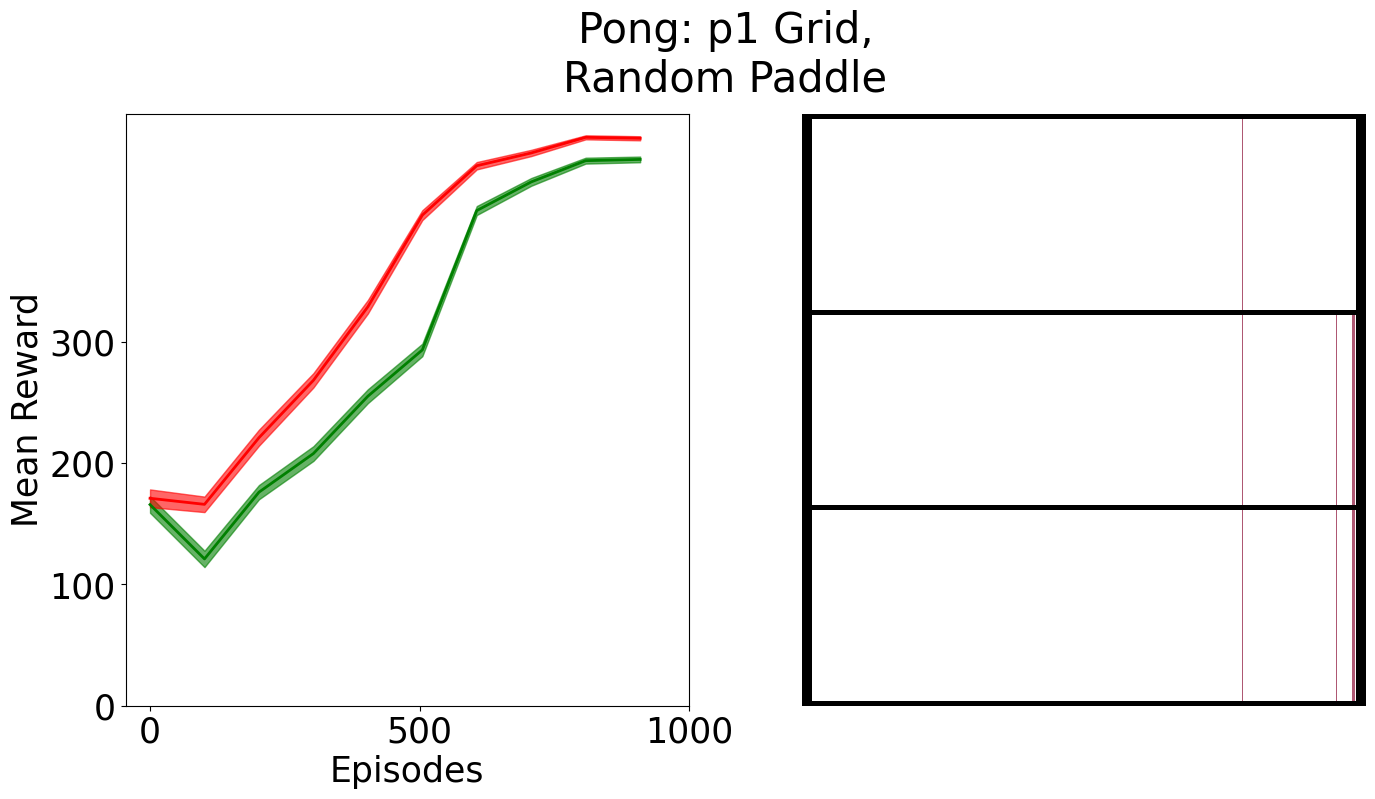

BoltzmannAgent, Boltzmann, pong, DirectionalComputerBar_{"index":1,"prob":0.6}, {"mean":0,"std":0}
BoltzmannAgent, Boltzmann, pong, ComputerBar_{"index":1,"prob":{}}, {"mean":0,"std":0}
BBpongDirectionalComputerBarindex1prob0.6mean0std0ComputerBarindex1probmean0std0
pongComputerBar{"index":1,"prob":{}} pongDirectionalComputerBar{"index":1,"prob":0.6}
saving  learnability BoltzmannAgent Boltzmann pongComputerBar{"index":1,"prob":{}} {"mean":0,"std":0} pongComputerBar{"index":1,"prob":{}} {"mean":0,"std":0}
The shape will be: 10
The shape will be: 10
[  0.         101.01010101 202.02020202 303.03030303 404.04040404
 505.05050505 606.06060606 707.07070707 808.08080808 909.09090909]
saving  generalization BoltzmannAgent Boltzmann pongComputerBar{"index":1,"prob":{}} {"mean":0,"std":0} pongDirectionalComputerBar{"index":1,"prob":0.6} {"mean":0,"std":0}
The shape will be: 10
The shape will be: 10
[  0.         101.01010101 202.02020202 303.03030303 404.04040404
 505.05050505 606.06060606 707

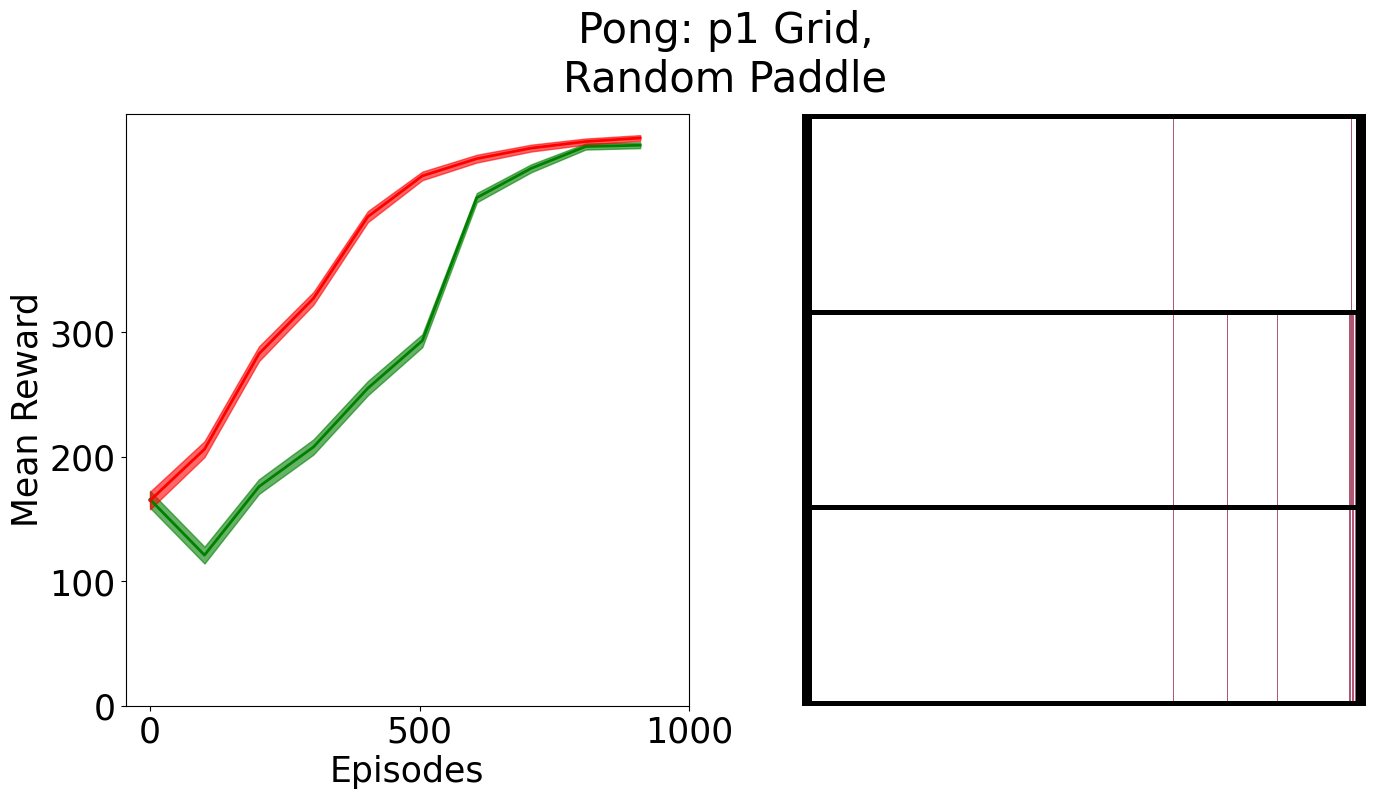

BoltzmannAgent, Boltzmann, pong-thick, DirectionalComputerBar_{"index":1,"prob":0.3}, {"mean":0,"std":0}
BoltzmannAgent, Boltzmann, pong-thick, ComputerBar_{"index":1,"prob":{}}, {"mean":0,"std":0}
BBpong-thickDirectionalComputerBarindex1prob0.3mean0std0ComputerBarindex1probmean0std0
pong-thickComputerBar{"index":1,"prob":{}} pong-thickDirectionalComputerBar{"index":1,"prob":0.3}
saving  learnability BoltzmannAgent Boltzmann pong-thickComputerBar{"index":1,"prob":{}} {"mean":0,"std":0} pong-thickComputerBar{"index":1,"prob":{}} {"mean":0,"std":0}
The shape will be: 10
The shape will be: 10
[  0.         101.01010101 202.02020202 303.03030303 404.04040404
 505.05050505 606.06060606 707.07070707 808.08080808 909.09090909]
saving  generalization BoltzmannAgent Boltzmann pong-thickComputerBar{"index":1,"prob":{}} {"mean":0,"std":0} pong-thickDirectionalComputerBar{"index":1,"prob":0.3} {"mean":0,"std":0}
The shape will be: 10
The shape will be: 10
[  0.         101.01010101 202.02020202 30

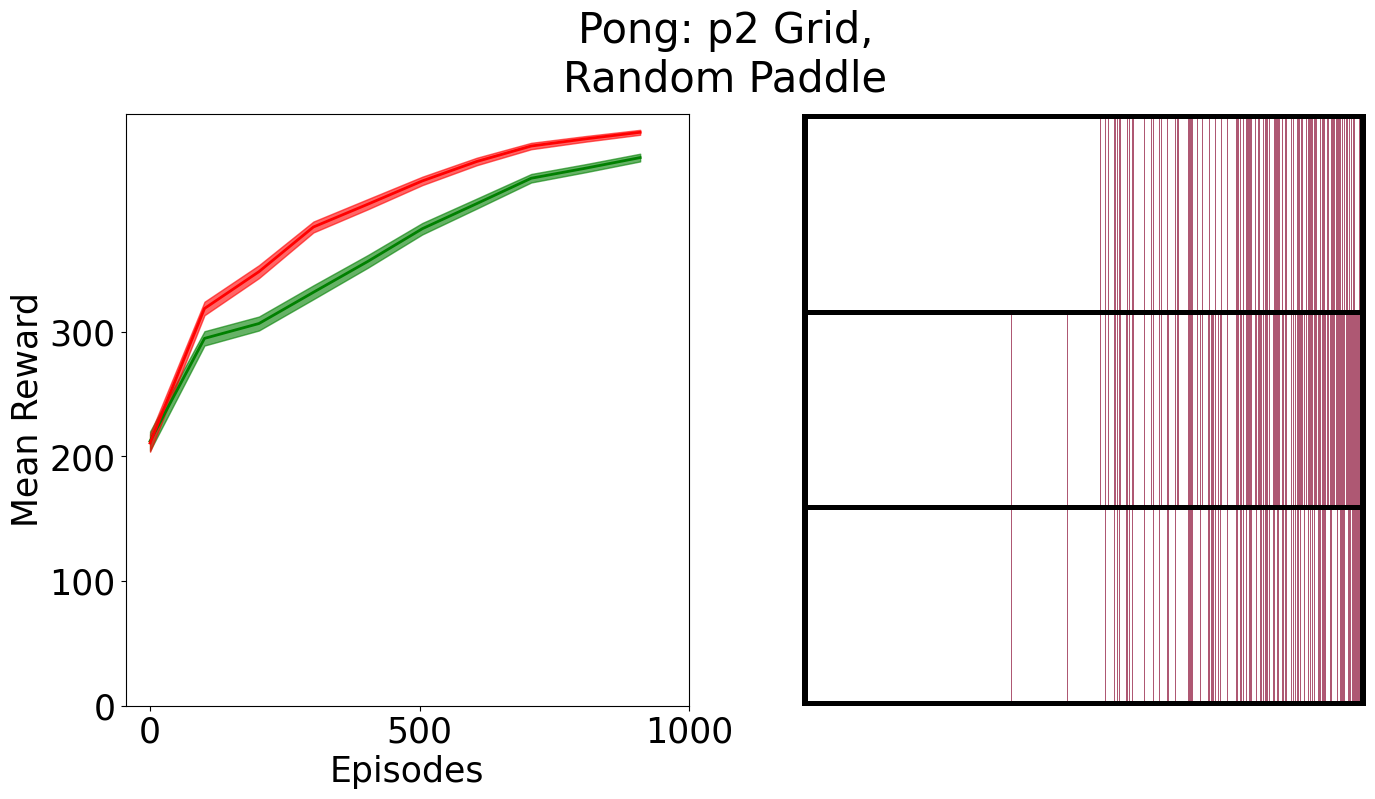

BoltzmannAgent, Boltzmann, pong-thick, DirectionalComputerBar_{"index":1,"prob":0.6}, {"mean":0,"std":0}
BoltzmannAgent, Boltzmann, pong-thick, ComputerBar_{"index":1,"prob":{}}, {"mean":0,"std":0}
BBpong-thickDirectionalComputerBarindex1prob0.6mean0std0ComputerBarindex1probmean0std0
pong-thickComputerBar{"index":1,"prob":{}} pong-thickDirectionalComputerBar{"index":1,"prob":0.6}
saving  learnability BoltzmannAgent Boltzmann pong-thickComputerBar{"index":1,"prob":{}} {"mean":0,"std":0} pong-thickComputerBar{"index":1,"prob":{}} {"mean":0,"std":0}
The shape will be: 10
The shape will be: 10
[  0.         101.01010101 202.02020202 303.03030303 404.04040404
 505.05050505 606.06060606 707.07070707 808.08080808 909.09090909]
saving  generalization BoltzmannAgent Boltzmann pong-thickComputerBar{"index":1,"prob":{}} {"mean":0,"std":0} pong-thickDirectionalComputerBar{"index":1,"prob":0.6} {"mean":0,"std":0}
The shape will be: 10
The shape will be: 10
[  0.         101.01010101 202.02020202 30

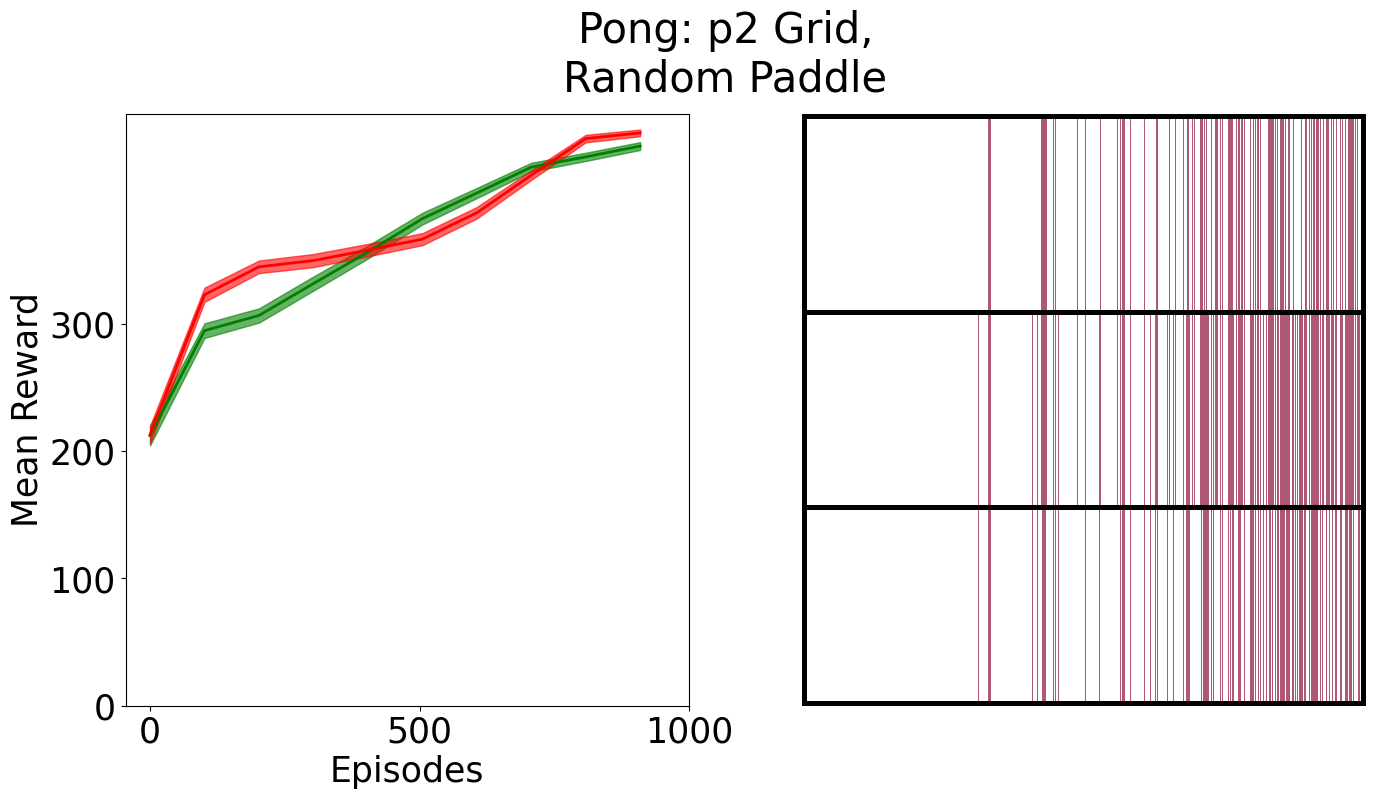

BoltzmannAgent, Egreedy, pong, DirectionalComputerBar_{"index":1,"prob":0.3}, {"mean":0,"std":0}
BoltzmannAgent, Egreedy, pong, ComputerBar_{"index":1,"prob":{}}, {"mean":0,"std":0}
BEpongDirectionalComputerBarindex1prob0.3mean0std0ComputerBarindex1probmean0std0
pongComputerBar{"index":1,"prob":{}} pongDirectionalComputerBar{"index":1,"prob":0.3}
saving  learnability BoltzmannAgent Egreedy pongComputerBar{"index":1,"prob":{}} {"mean":0,"std":0} pongComputerBar{"index":1,"prob":{}} {"mean":0,"std":0}
The shape will be: 10
The shape will be: 10
[  0.         101.01010101 202.02020202 303.03030303 404.04040404
 505.05050505 606.06060606 707.07070707 808.08080808 909.09090909]
saving  generalization BoltzmannAgent Egreedy pongComputerBar{"index":1,"prob":{}} {"mean":0,"std":0} pongDirectionalComputerBar{"index":1,"prob":0.3} {"mean":0,"std":0}
The shape will be: 10
The shape will be: 10
[  0.         101.01010101 202.02020202 303.03030303 404.04040404
 505.05050505 606.06060606 707.0707070

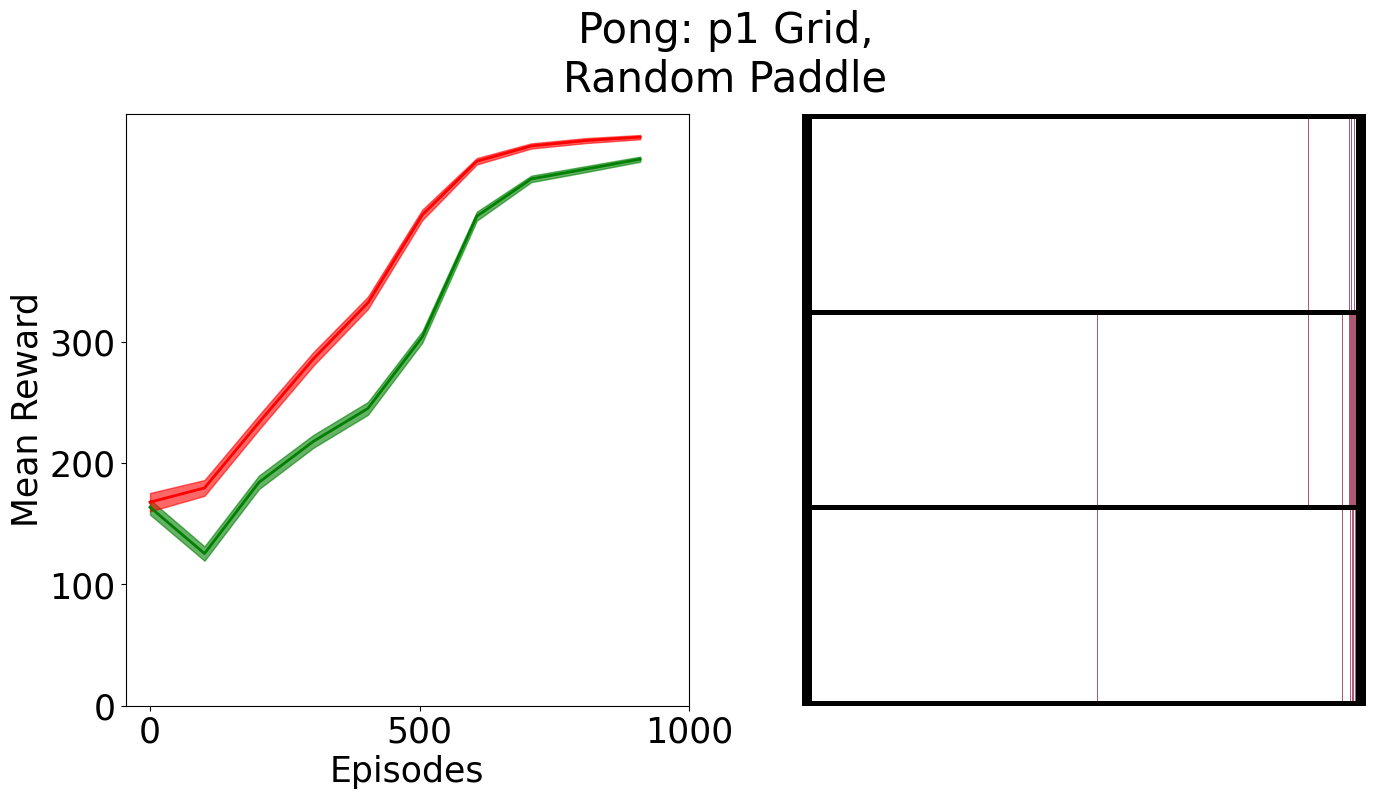

BoltzmannAgent, Egreedy, pong, DirectionalComputerBar_{"index":1,"prob":0.6}, {"mean":0,"std":0}
BoltzmannAgent, Egreedy, pong, ComputerBar_{"index":1,"prob":{}}, {"mean":0,"std":0}
BEpongDirectionalComputerBarindex1prob0.6mean0std0ComputerBarindex1probmean0std0
pongComputerBar{"index":1,"prob":{}} pongDirectionalComputerBar{"index":1,"prob":0.6}
saving  learnability BoltzmannAgent Egreedy pongComputerBar{"index":1,"prob":{}} {"mean":0,"std":0} pongComputerBar{"index":1,"prob":{}} {"mean":0,"std":0}
The shape will be: 10
The shape will be: 10
[  0.         101.01010101 202.02020202 303.03030303 404.04040404
 505.05050505 606.06060606 707.07070707 808.08080808 909.09090909]
saving  generalization BoltzmannAgent Egreedy pongComputerBar{"index":1,"prob":{}} {"mean":0,"std":0} pongDirectionalComputerBar{"index":1,"prob":0.6} {"mean":0,"std":0}
The shape will be: 10
The shape will be: 10
[  0.         101.01010101 202.02020202 303.03030303 404.04040404
 505.05050505 606.06060606 707.0707070

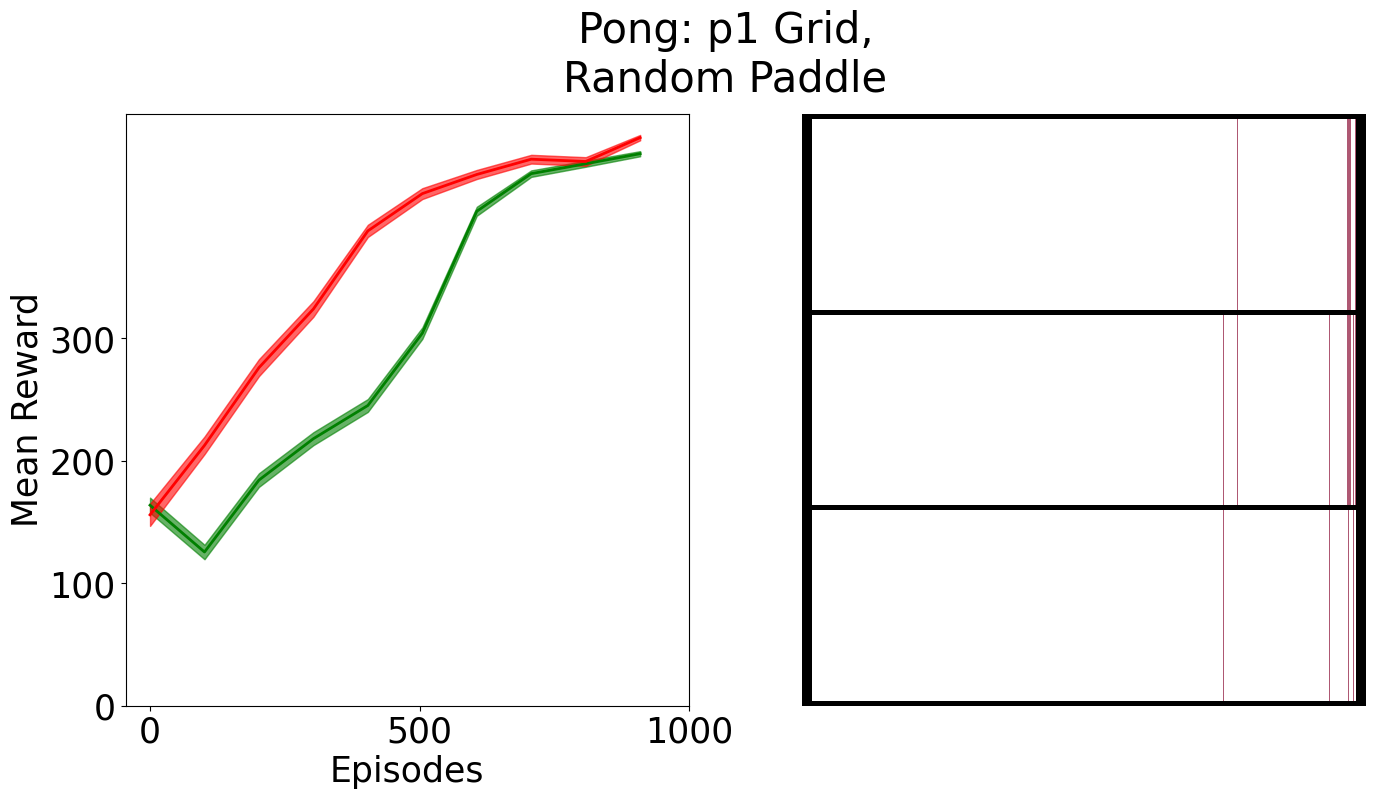

BoltzmannAgent, Egreedy, pong-thick, DirectionalComputerBar_{"index":1,"prob":0.3}, {"mean":0,"std":0}
BoltzmannAgent, Egreedy, pong-thick, ComputerBar_{"index":1,"prob":{}}, {"mean":0,"std":0}
BEpong-thickDirectionalComputerBarindex1prob0.3mean0std0ComputerBarindex1probmean0std0
pong-thickComputerBar{"index":1,"prob":{}} pong-thickDirectionalComputerBar{"index":1,"prob":0.3}
saving  learnability BoltzmannAgent Egreedy pong-thickComputerBar{"index":1,"prob":{}} {"mean":0,"std":0} pong-thickComputerBar{"index":1,"prob":{}} {"mean":0,"std":0}
The shape will be: 10
The shape will be: 10
[  0.         101.01010101 202.02020202 303.03030303 404.04040404
 505.05050505 606.06060606 707.07070707 808.08080808 909.09090909]
saving  generalization BoltzmannAgent Egreedy pong-thickComputerBar{"index":1,"prob":{}} {"mean":0,"std":0} pong-thickDirectionalComputerBar{"index":1,"prob":0.3} {"mean":0,"std":0}
The shape will be: 10
The shape will be: 10
[  0.         101.01010101 202.02020202 303.030303

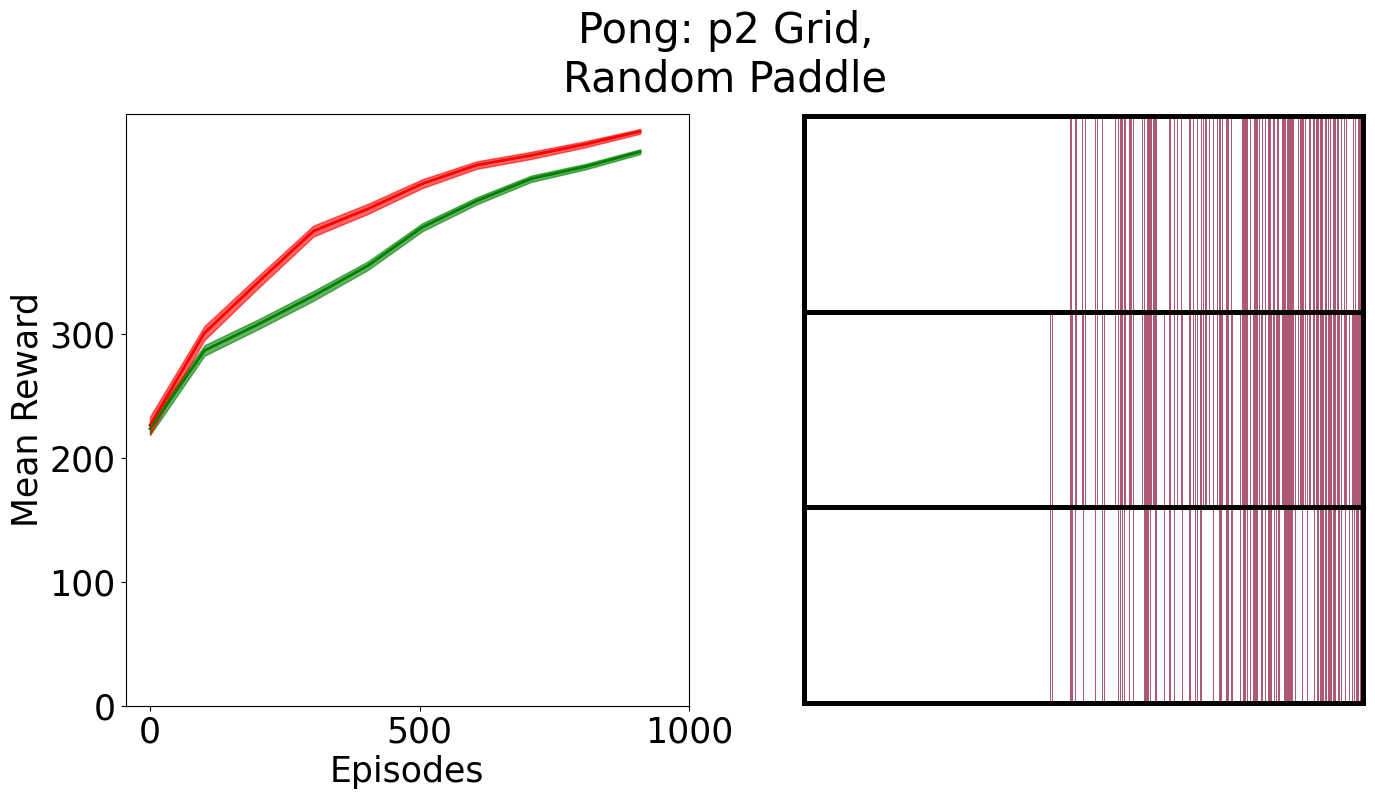

BoltzmannAgent, Egreedy, pong-thick, DirectionalComputerBar_{"index":1,"prob":0.6}, {"mean":0,"std":0}
BoltzmannAgent, Egreedy, pong-thick, ComputerBar_{"index":1,"prob":{}}, {"mean":0,"std":0}
BEpong-thickDirectionalComputerBarindex1prob0.6mean0std0ComputerBarindex1probmean0std0
pong-thickComputerBar{"index":1,"prob":{}} pong-thickDirectionalComputerBar{"index":1,"prob":0.6}
saving  learnability BoltzmannAgent Egreedy pong-thickComputerBar{"index":1,"prob":{}} {"mean":0,"std":0} pong-thickComputerBar{"index":1,"prob":{}} {"mean":0,"std":0}
The shape will be: 10
The shape will be: 10
[  0.         101.01010101 202.02020202 303.03030303 404.04040404
 505.05050505 606.06060606 707.07070707 808.08080808 909.09090909]
saving  generalization BoltzmannAgent Egreedy pong-thickComputerBar{"index":1,"prob":{}} {"mean":0,"std":0} pong-thickDirectionalComputerBar{"index":1,"prob":0.6} {"mean":0,"std":0}
The shape will be: 10
The shape will be: 10
[  0.         101.01010101 202.02020202 303.030303

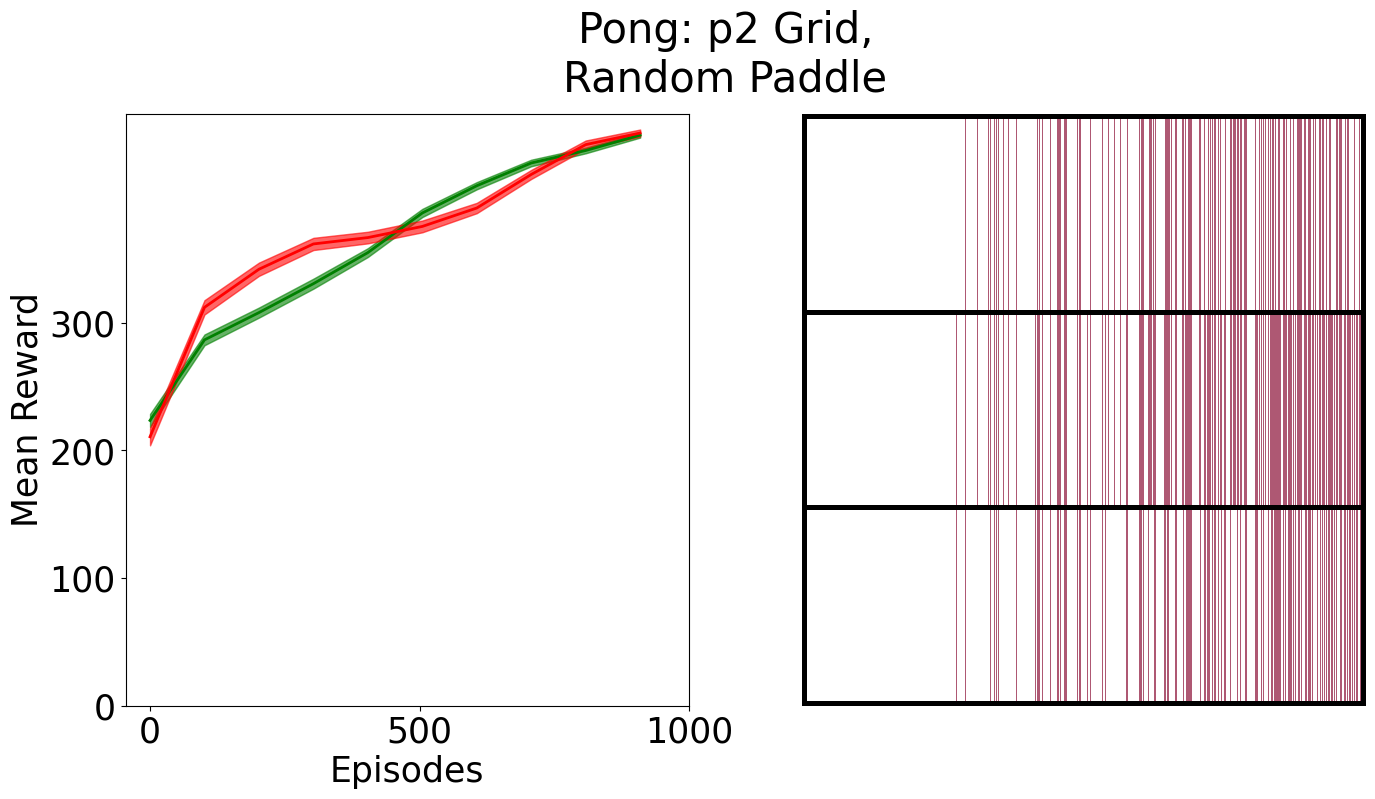

SarsaAgent, Boltzmann, pong, DirectionalComputerBar_{"index":1,"prob":0.3}, {"mean":0,"std":0}
SarsaAgent, Boltzmann, pong, ComputerBar_{"index":1,"prob":{}}, {"mean":0,"std":0}
SBpongDirectionalComputerBarindex1prob0.3mean0std0ComputerBarindex1probmean0std0
pongComputerBar{"index":1,"prob":{}} pongDirectionalComputerBar{"index":1,"prob":0.3}
saving  learnability SarsaAgent Boltzmann pongComputerBar{"index":1,"prob":{}} {"mean":0,"std":0} pongComputerBar{"index":1,"prob":{}} {"mean":0,"std":0}
The shape will be: 10
The shape will be: 10
[  0.         101.01010101 202.02020202 303.03030303 404.04040404
 505.05050505 606.06060606 707.07070707 808.08080808 909.09090909]
saving  generalization SarsaAgent Boltzmann pongComputerBar{"index":1,"prob":{}} {"mean":0,"std":0} pongDirectionalComputerBar{"index":1,"prob":0.3} {"mean":0,"std":0}
The shape will be: 10
The shape will be: 10
[  0.         101.01010101 202.02020202 303.03030303 404.04040404
 505.05050505 606.06060606 707.07070707 808.08

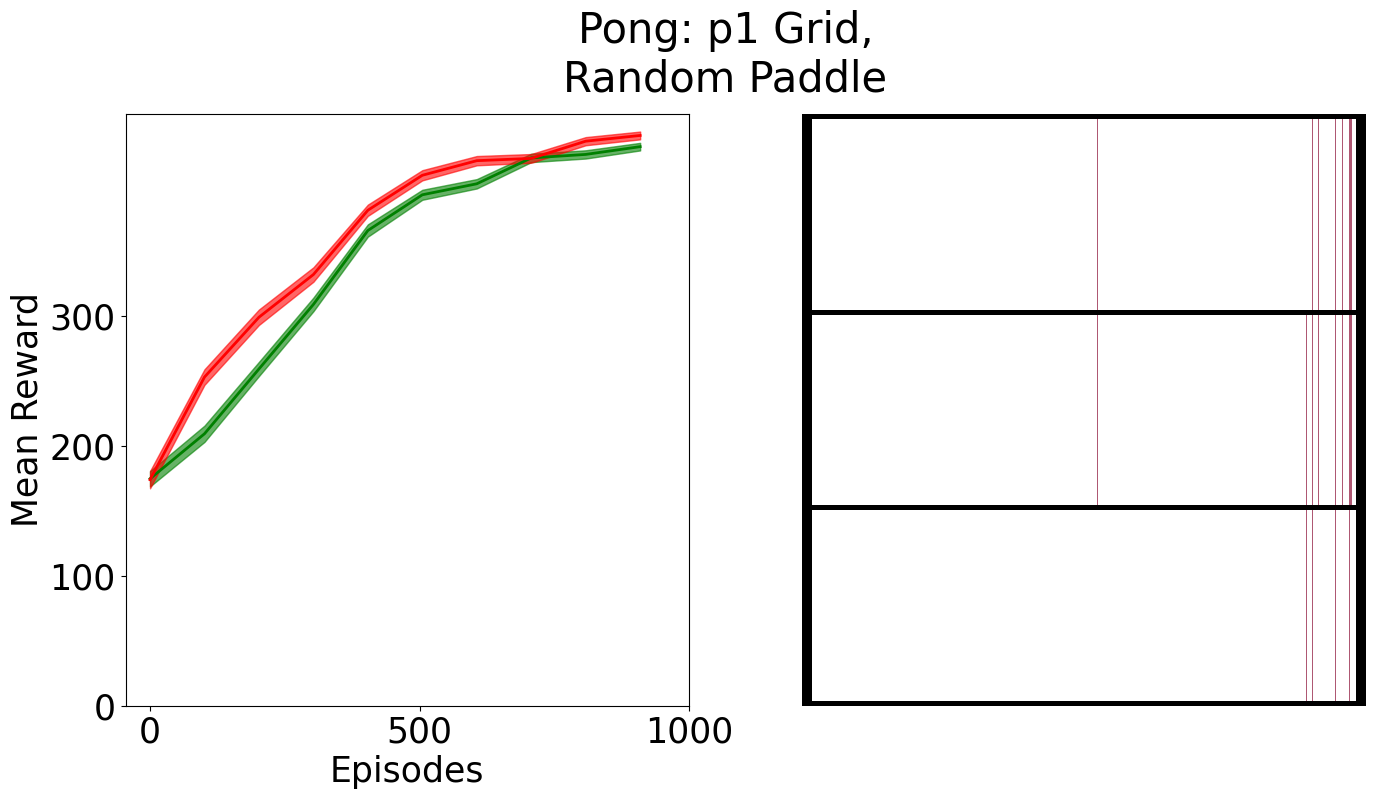

SarsaAgent, Boltzmann, pong, DirectionalComputerBar_{"index":1,"prob":0.6}, {"mean":0,"std":0}
SarsaAgent, Boltzmann, pong, ComputerBar_{"index":1,"prob":{}}, {"mean":0,"std":0}
SBpongDirectionalComputerBarindex1prob0.6mean0std0ComputerBarindex1probmean0std0
pongComputerBar{"index":1,"prob":{}} pongDirectionalComputerBar{"index":1,"prob":0.6}
saving  learnability SarsaAgent Boltzmann pongComputerBar{"index":1,"prob":{}} {"mean":0,"std":0} pongComputerBar{"index":1,"prob":{}} {"mean":0,"std":0}
The shape will be: 10
The shape will be: 10
[  0.         101.01010101 202.02020202 303.03030303 404.04040404
 505.05050505 606.06060606 707.07070707 808.08080808 909.09090909]
saving  generalization SarsaAgent Boltzmann pongComputerBar{"index":1,"prob":{}} {"mean":0,"std":0} pongDirectionalComputerBar{"index":1,"prob":0.6} {"mean":0,"std":0}
The shape will be: 10
The shape will be: 10
[  0.         101.01010101 202.02020202 303.03030303 404.04040404
 505.05050505 606.06060606 707.07070707 808.08

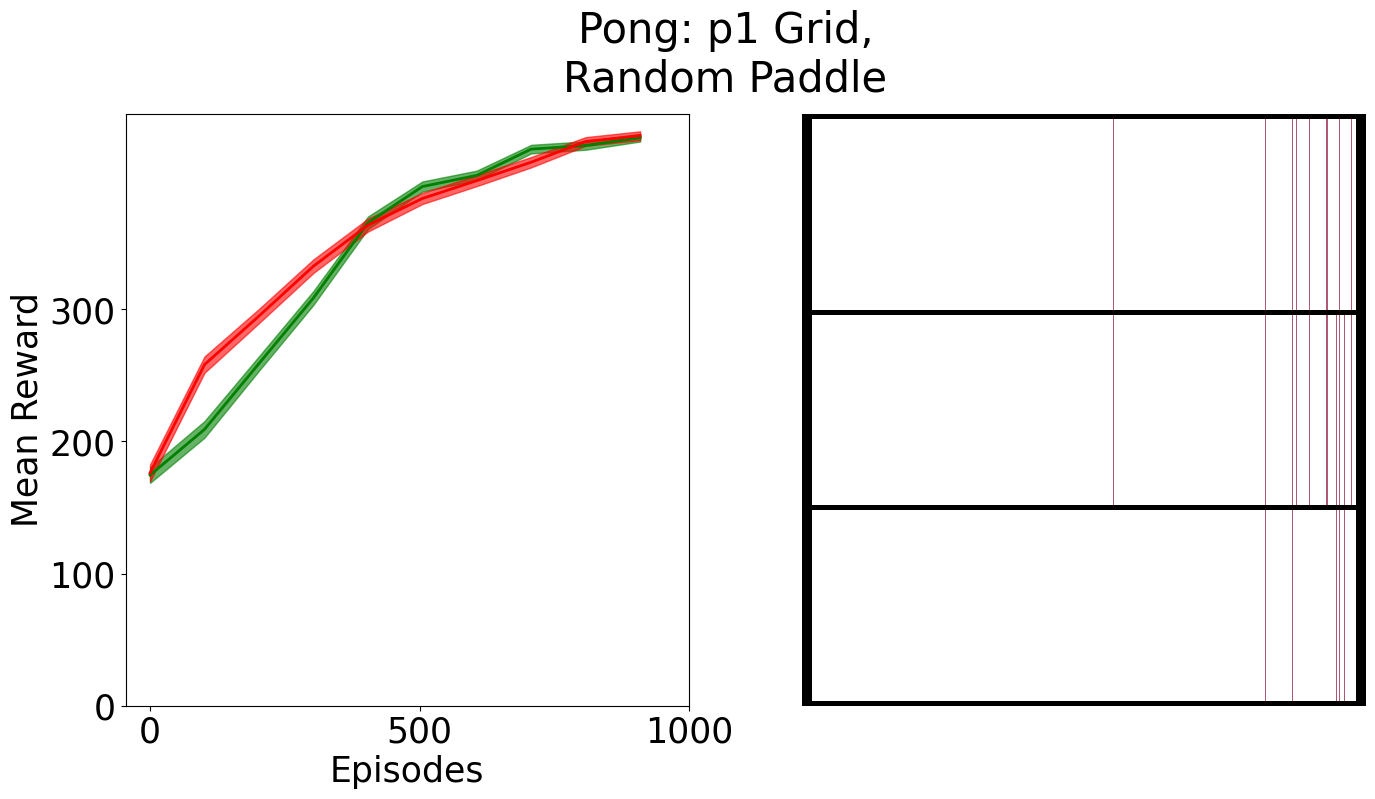

SarsaAgent, Boltzmann, pong-thick, DirectionalComputerBar_{"index":1,"prob":0.3}, {"mean":0,"std":0}
SarsaAgent, Boltzmann, pong-thick, ComputerBar_{"index":1,"prob":{}}, {"mean":0,"std":0}
SBpong-thickDirectionalComputerBarindex1prob0.3mean0std0ComputerBarindex1probmean0std0
pong-thickComputerBar{"index":1,"prob":{}} pong-thickDirectionalComputerBar{"index":1,"prob":0.3}
saving  learnability SarsaAgent Boltzmann pong-thickComputerBar{"index":1,"prob":{}} {"mean":0,"std":0} pong-thickComputerBar{"index":1,"prob":{}} {"mean":0,"std":0}
The shape will be: 10
The shape will be: 10
[  0.         101.01010101 202.02020202 303.03030303 404.04040404
 505.05050505 606.06060606 707.07070707 808.08080808 909.09090909]
saving  generalization SarsaAgent Boltzmann pong-thickComputerBar{"index":1,"prob":{}} {"mean":0,"std":0} pong-thickDirectionalComputerBar{"index":1,"prob":0.3} {"mean":0,"std":0}
The shape will be: 10
The shape will be: 10
[  0.         101.01010101 202.02020202 303.03030303 404.0

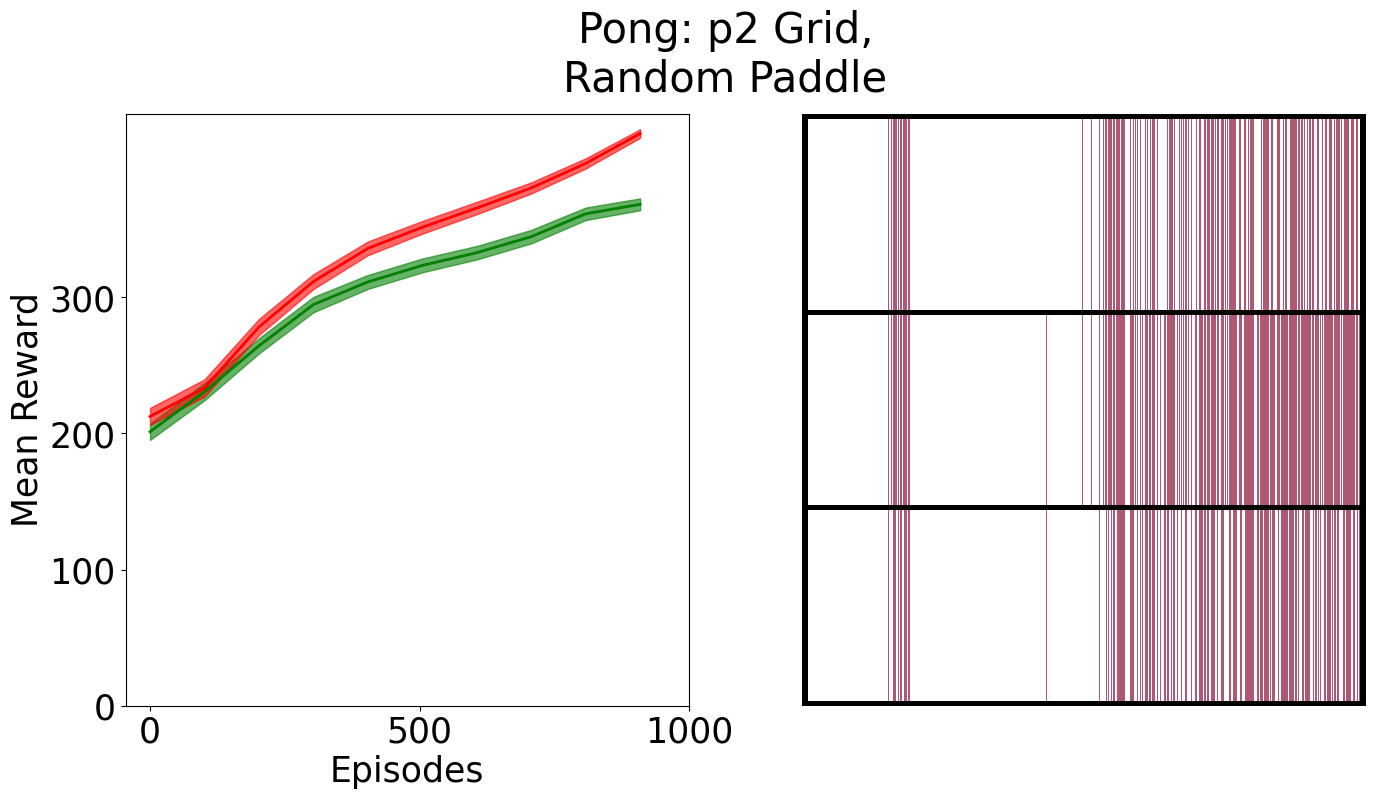

SarsaAgent, Boltzmann, pong-thick, DirectionalComputerBar_{"index":1,"prob":0.6}, {"mean":0,"std":0}
SarsaAgent, Boltzmann, pong-thick, ComputerBar_{"index":1,"prob":{}}, {"mean":0,"std":0}
SBpong-thickDirectionalComputerBarindex1prob0.6mean0std0ComputerBarindex1probmean0std0
pong-thickComputerBar{"index":1,"prob":{}} pong-thickDirectionalComputerBar{"index":1,"prob":0.6}
saving  learnability SarsaAgent Boltzmann pong-thickComputerBar{"index":1,"prob":{}} {"mean":0,"std":0} pong-thickComputerBar{"index":1,"prob":{}} {"mean":0,"std":0}
The shape will be: 10
The shape will be: 10
[  0.         101.01010101 202.02020202 303.03030303 404.04040404
 505.05050505 606.06060606 707.07070707 808.08080808 909.09090909]
saving  generalization SarsaAgent Boltzmann pong-thickComputerBar{"index":1,"prob":{}} {"mean":0,"std":0} pong-thickDirectionalComputerBar{"index":1,"prob":0.6} {"mean":0,"std":0}
The shape will be: 10
The shape will be: 10
[  0.         101.01010101 202.02020202 303.03030303 404.0

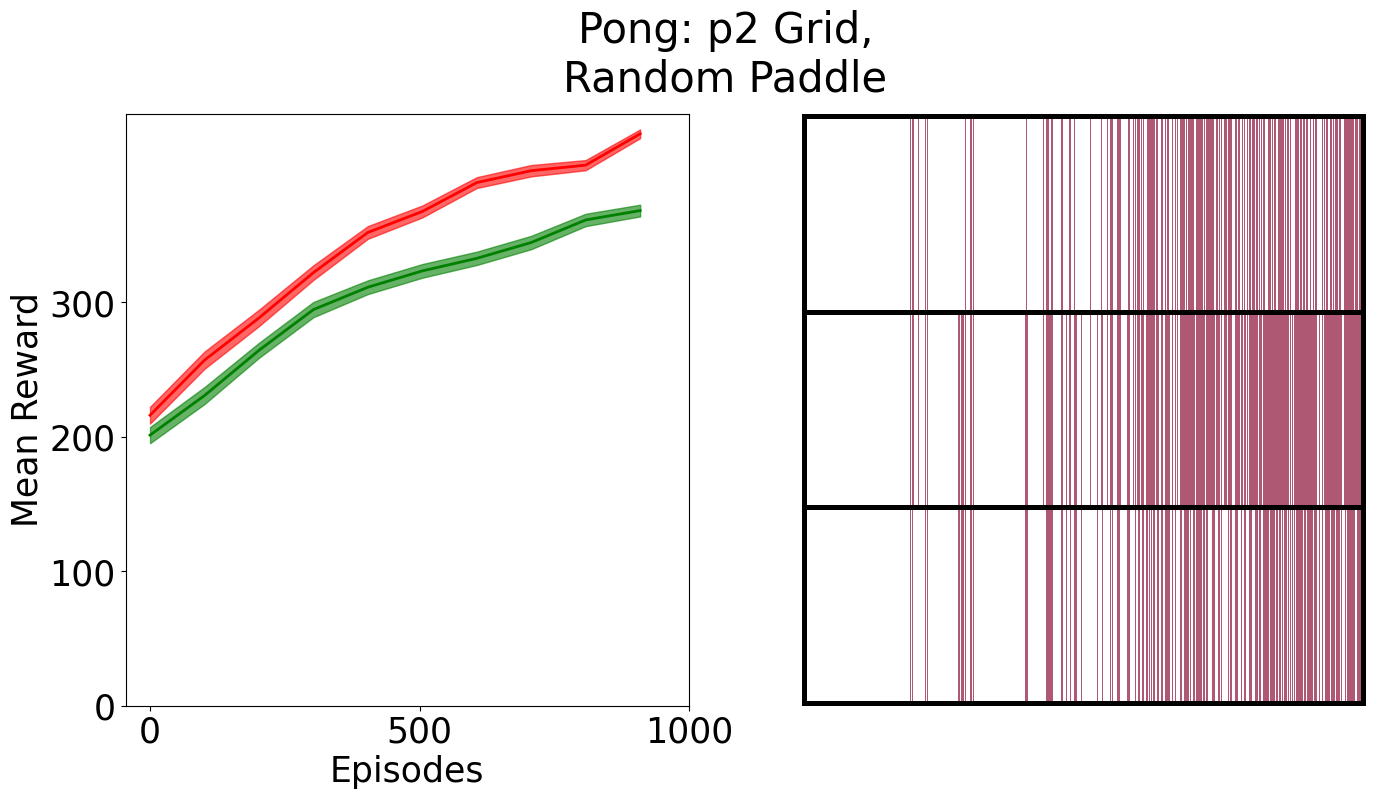

SarsaAgent, Egreedy, pong, DirectionalComputerBar_{"index":1,"prob":0.3}, {"mean":0,"std":0}
SarsaAgent, Egreedy, pong, ComputerBar_{"index":1,"prob":{}}, {"mean":0,"std":0}
SEpongDirectionalComputerBarindex1prob0.3mean0std0ComputerBarindex1probmean0std0
pongComputerBar{"index":1,"prob":{}} pongDirectionalComputerBar{"index":1,"prob":0.3}
saving  learnability SarsaAgent Egreedy pongComputerBar{"index":1,"prob":{}} {"mean":0,"std":0} pongComputerBar{"index":1,"prob":{}} {"mean":0,"std":0}
The shape will be: 10
The shape will be: 10
[  0.         101.01010101 202.02020202 303.03030303 404.04040404
 505.05050505 606.06060606 707.07070707 808.08080808 909.09090909]
saving  generalization SarsaAgent Egreedy pongComputerBar{"index":1,"prob":{}} {"mean":0,"std":0} pongDirectionalComputerBar{"index":1,"prob":0.3} {"mean":0,"std":0}
The shape will be: 10
The shape will be: 10
[  0.         101.01010101 202.02020202 303.03030303 404.04040404
 505.05050505 606.06060606 707.07070707 808.08080808 9

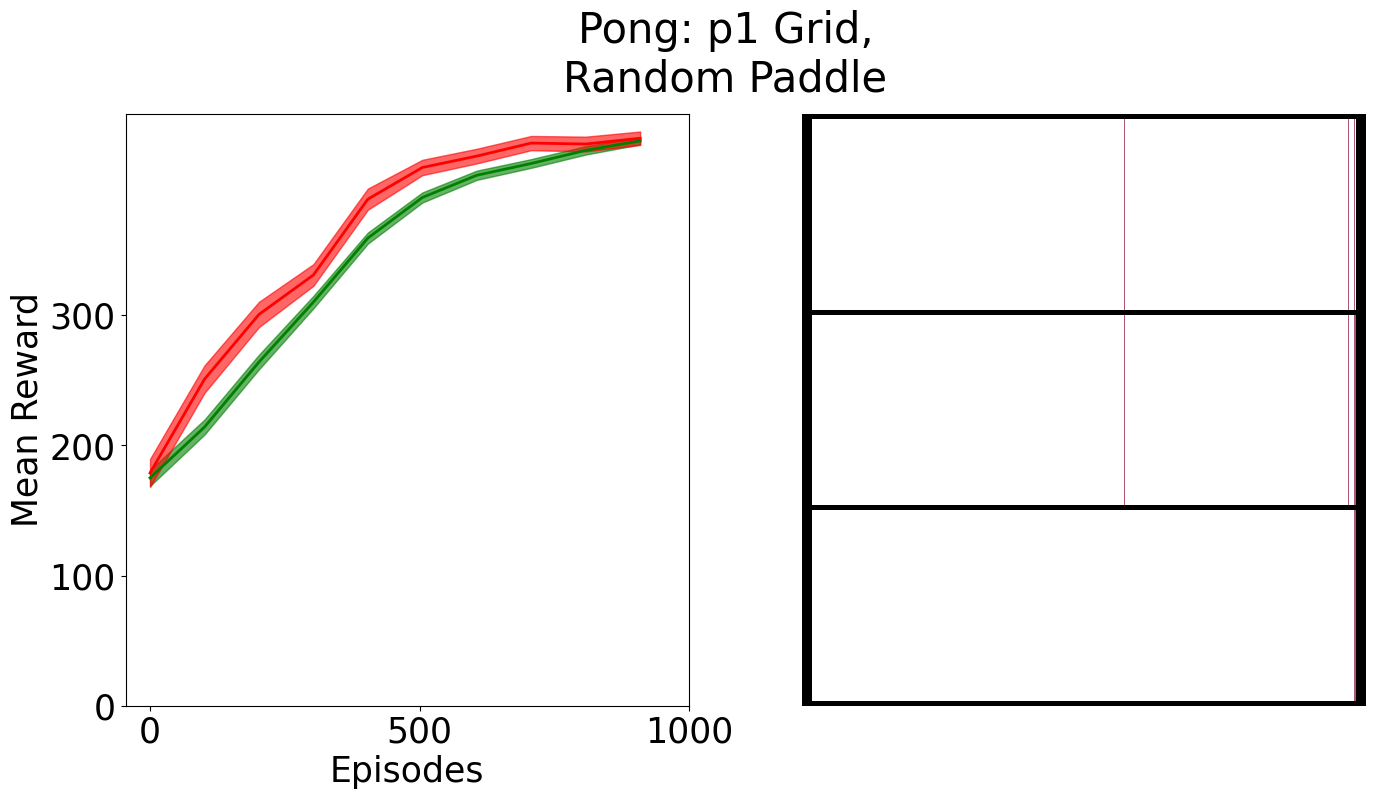

SarsaAgent, Egreedy, pong, DirectionalComputerBar_{"index":1,"prob":0.6}, {"mean":0,"std":0}
SarsaAgent, Egreedy, pong, ComputerBar_{"index":1,"prob":{}}, {"mean":0,"std":0}
SEpongDirectionalComputerBarindex1prob0.6mean0std0ComputerBarindex1probmean0std0
pongComputerBar{"index":1,"prob":{}} pongDirectionalComputerBar{"index":1,"prob":0.6}
saving  learnability SarsaAgent Egreedy pongComputerBar{"index":1,"prob":{}} {"mean":0,"std":0} pongComputerBar{"index":1,"prob":{}} {"mean":0,"std":0}
The shape will be: 10
The shape will be: 10
[  0.         101.01010101 202.02020202 303.03030303 404.04040404
 505.05050505 606.06060606 707.07070707 808.08080808 909.09090909]
saving  generalization SarsaAgent Egreedy pongComputerBar{"index":1,"prob":{}} {"mean":0,"std":0} pongDirectionalComputerBar{"index":1,"prob":0.6} {"mean":0,"std":0}
The shape will be: 10
The shape will be: 10
[  0.         101.01010101 202.02020202 303.03030303 404.04040404
 505.05050505 606.06060606 707.07070707 808.08080808 9

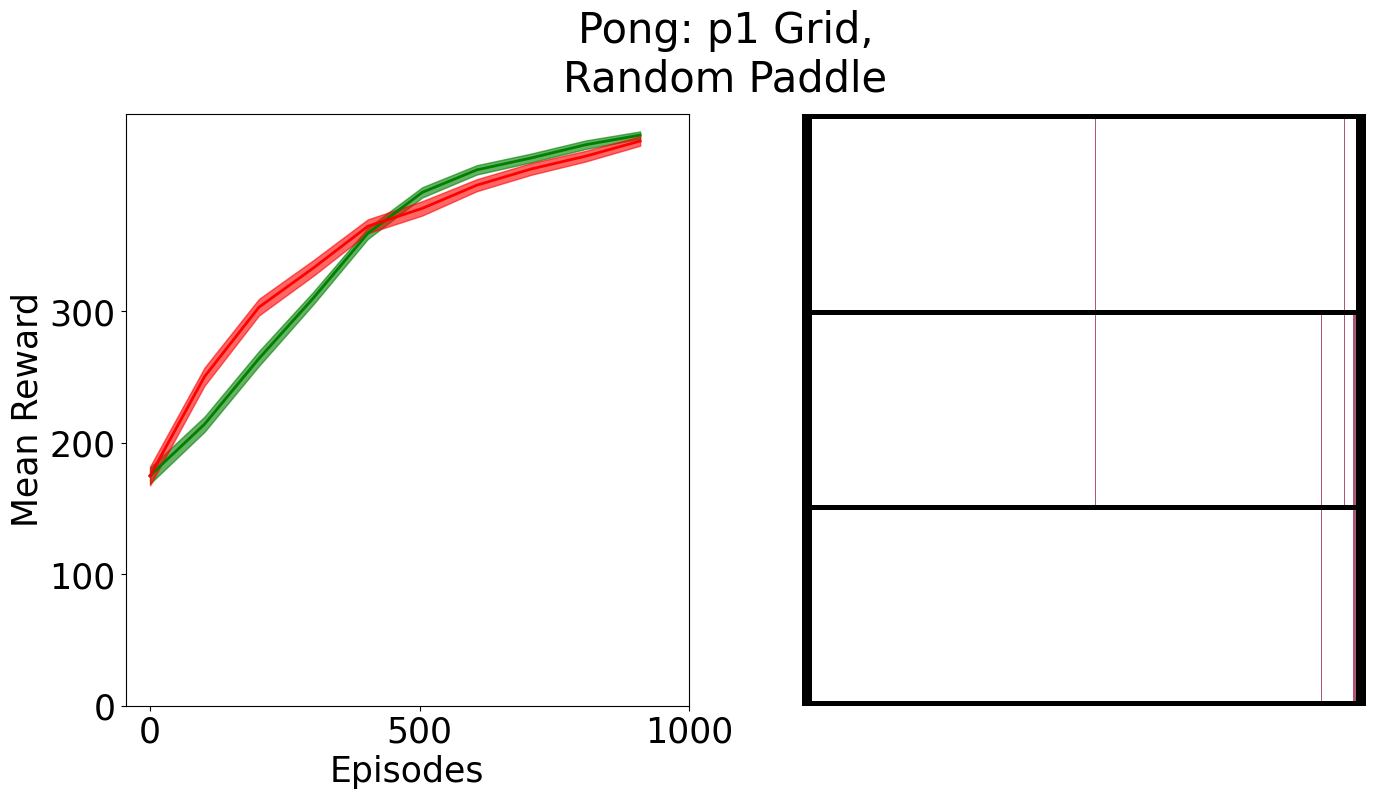

SarsaAgent, Egreedy, pong-thick, DirectionalComputerBar_{"index":1,"prob":0.3}, {"mean":0,"std":0}
SarsaAgent, Egreedy, pong-thick, ComputerBar_{"index":1,"prob":{}}, {"mean":0,"std":0}
SEpong-thickDirectionalComputerBarindex1prob0.3mean0std0ComputerBarindex1probmean0std0
pong-thickComputerBar{"index":1,"prob":{}} pong-thickDirectionalComputerBar{"index":1,"prob":0.3}
saving  learnability SarsaAgent Egreedy pong-thickComputerBar{"index":1,"prob":{}} {"mean":0,"std":0} pong-thickComputerBar{"index":1,"prob":{}} {"mean":0,"std":0}
The shape will be: 10
The shape will be: 10
[  0.         101.01010101 202.02020202 303.03030303 404.04040404
 505.05050505 606.06060606 707.07070707 808.08080808 909.09090909]
saving  generalization SarsaAgent Egreedy pong-thickComputerBar{"index":1,"prob":{}} {"mean":0,"std":0} pong-thickDirectionalComputerBar{"index":1,"prob":0.3} {"mean":0,"std":0}
The shape will be: 10
The shape will be: 10
[  0.         101.01010101 202.02020202 303.03030303 404.04040404


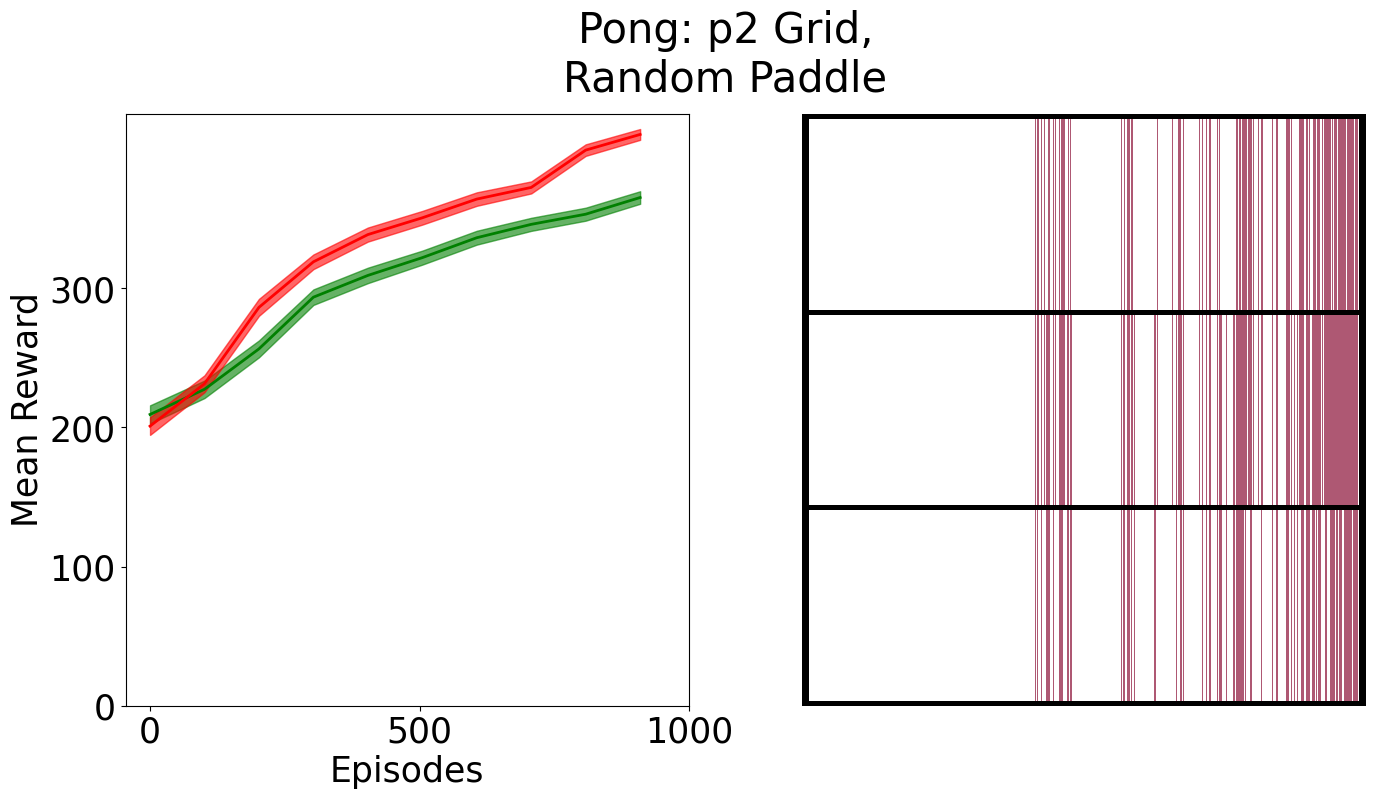

SarsaAgent, Egreedy, pong-thick, DirectionalComputerBar_{"index":1,"prob":0.6}, {"mean":0,"std":0}
SarsaAgent, Egreedy, pong-thick, ComputerBar_{"index":1,"prob":{}}, {"mean":0,"std":0}
SEpong-thickDirectionalComputerBarindex1prob0.6mean0std0ComputerBarindex1probmean0std0
pong-thickComputerBar{"index":1,"prob":{}} pong-thickDirectionalComputerBar{"index":1,"prob":0.6}
saving  learnability SarsaAgent Egreedy pong-thickComputerBar{"index":1,"prob":{}} {"mean":0,"std":0} pong-thickComputerBar{"index":1,"prob":{}} {"mean":0,"std":0}
The shape will be: 10
The shape will be: 10
[  0.         101.01010101 202.02020202 303.03030303 404.04040404
 505.05050505 606.06060606 707.07070707 808.08080808 909.09090909]
saving  generalization SarsaAgent Egreedy pong-thickComputerBar{"index":1,"prob":{}} {"mean":0,"std":0} pong-thickDirectionalComputerBar{"index":1,"prob":0.6} {"mean":0,"std":0}
The shape will be: 10
The shape will be: 10
[  0.         101.01010101 202.02020202 303.03030303 404.04040404


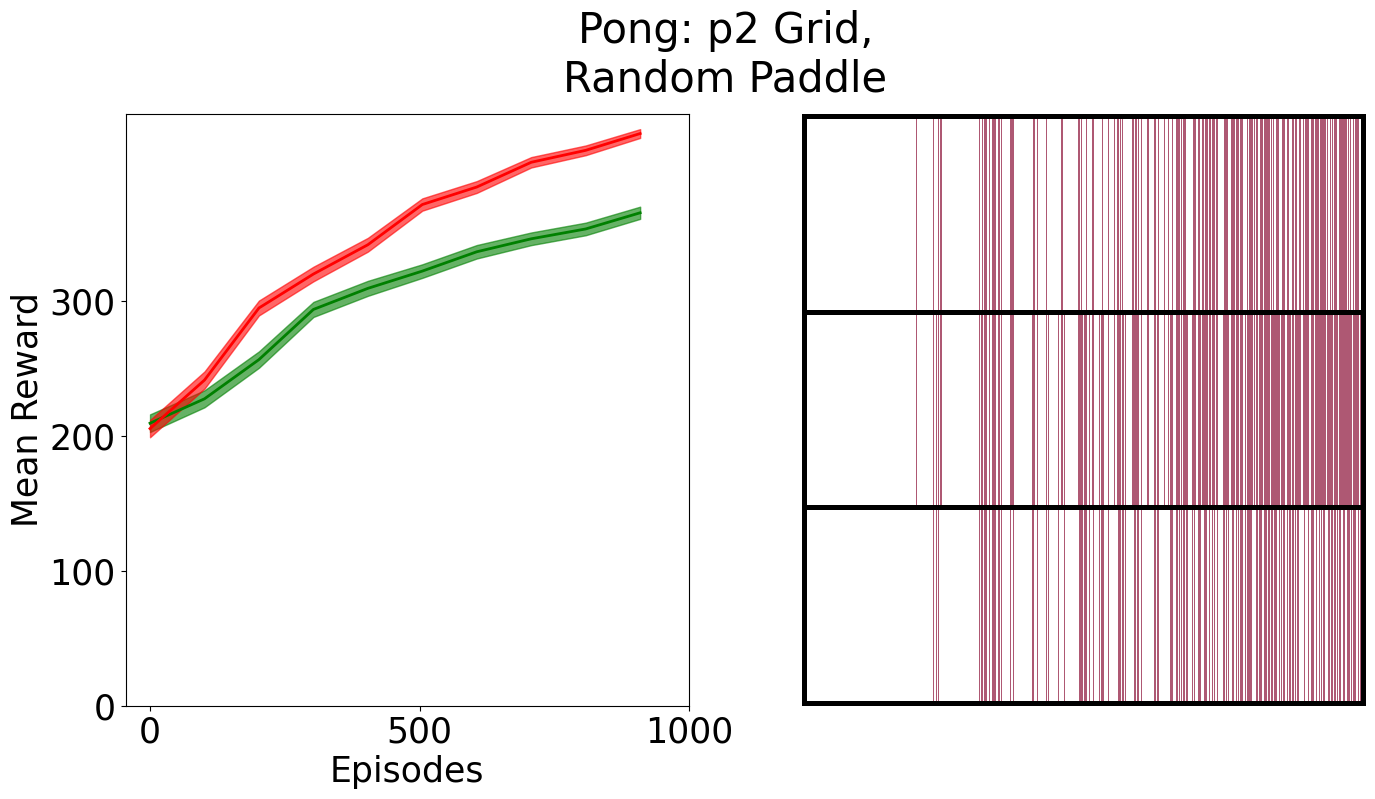

In [17]:
# choose EPOCH from 0-199
import re
EPOCH=199
stacked_binarized_sa_pairs= None
name_mapping ={"agents":{"ComputerBar":"Random Paddle", "DirectionalComputerBar":"Following Paddle"},"grids":{"pong":"p1","pong-thick":"p2"}}

paper_occupancy_grids = []
for someagent in someagent_l:
    if someagent not in name:
        continue
    for someexploration_strategy in someexploration_strategy_l:
        if someexploration_strategy not in name[someagent]:
            continue
        for somegrid in somegrid_l:
            if somegrid not in name[someagent][someexploration_strategy]:
                continue
            for somebar, somenoise, someotherbar, someothernoise in zip(somebar_l, somenoise_l, someotherbar_l, someothernoise_l):
                if somebar not in name[someagent][someexploration_strategy][somegrid]:
                    continue
                if somenoise not in name[someagent][someexploration_strategy][somegrid][somebar]:
                    continue
                a = generate_occupancy_binarized(someagent, someexploration_strategy,somegrid, somebar, somenoise, someotherbar, someothernoise, EPOCH)
                save_name=  '_'.join([someagent[0], someexploration_strategy[0] ,somegrid, somebar, somenoise, someotherbar, someothernoise])
                save_name = re.sub(r'[%$#&{},_~^\\:"\']', '', save_name)
                print(save_name)
                fig, ax = plt.subplots(1,2, figsize=(16,8))
                
                display_as_image_2(a,'exploration_grid/%s.pdf'%save_name, ax=ax[1])
                contragents_test=f'{somegrid}{someotherbar.replace("_","")}'
                contragents_ensemble=f'{somegrid}{somebar.replace("_","")}'
                print(contragents_test, contragents_ensemble)
                title_fig = plot(ax[0],"pong",["learnability","generalization"],someagent, someexploration_strategy, name_mapping=name_mapping, contragents_test=contragents_test,contragents_ensemble=[[contragents_test],[contragents_ensemble]], noise_test=[someothernoise])
                plt.suptitle(f"{title_fig}\n",fontsize=30)
                plt.subplots_adjust(top=0.85)
                plt.savefig(f"exploration_grid/{save_name}.pdf")
                plt.show()

In [ ]:


# names = ['noisy_v2.pdf', 'noisy_v3.pdf', 'semantic_v2.pdf', 'semantic_v3.pdf']
# ct = 0
# for grid in paper_occupancy_grids:
#     display_as_image_2(grid, '/content/%s'%names[ct])
#     ct += 1


In [ ]:
#a = np.asarray(generate_occupancy_binarized(folder,subfolder,agent, exploration_strategy,somegrid, somebar, somenoise, someotherbar, someothernoise, EPOCH))

In [ ]:
# cmap_colors = ['blue', 'white', 'red','black']
# cmap_values = [-1, 0, 1, 2]  # Adjust these values based on your data range

# # Create a colormap using ListedColormap
# custom_cmap = ListedColormap(cmap_colors, name='custom_cmap')
# plt.imshow(a, cmap=custom_cmap, interpolation='nearest', vmin=min(cmap_values), vmax=max(cmap_values))
# plt.colorbar()

# # Show the plot
# plt.show()

In [ ]:
# np.unique(a)
# cmap = ListedColormap(colors)

# value_to_color = {-1: pink_color, 0: 'white', 1: 'red'}
# colorblind_blue = sns.color_palette("deep")[0]
# gray_color = [117/255, 117/255, 117/255]
# pink_color = [174/255, 88/255, 115/255]
# blue_color = [71/255,114/255,173/255]

# colors = [pink_color, 'white', 'black']
# unique_values = np.unique(a)
# colors = [value_to_color[val] for val in unique_values if val in value_to_color]
# # Map the unique values of 'a' to the range [0, 1, ..., N-1], where N is the number of unique values
# value_to_index = {val: i for i, val in enumerate(unique_values)}
# mapped_values = np.vectorize(value_to_index.get)(a)


In [ ]:
# a.shape

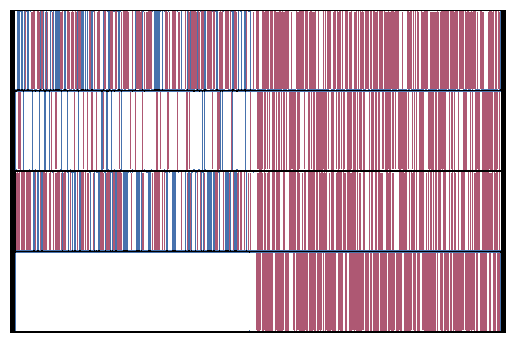

In [ ]:
dislpay_as_image(a, '/content/binarized.pdf')

In [ ]:
# Statistical Testing Plots

pong_means = {'G>L':1.22, 'L>G':2.75}
pong_sem = {'G>L':0.001, 'L>G':0.002}

pacman_means = {'G>L':8.36, 'L>G':27.1}
pacman_sem = {'G>L':0.011, 'L>G':0.017}


In [ ]:
print(sns.color_palette().as_hex())



['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [ ]:
def add_significance_bar(x1,x2,y,h,text,line_color='black', text_color='black'):
    plt.plot([x1,x1,x2,x2], [y, y+h, y+h, y], lw=1.5, c=line_color)
    plt.text((x1+x2)*.5, y+0.005, text, ha='center', va='bottom', color=text_color,fontsize=24)

In [ ]:
def plot_significant_bar(vals, errs, savename):
    plt.figure()
    palette = ['gray','#8c564b']
    plt.bar([0,1], vals, width=0.8, color=palette, yerr=errs,capsize=5)
    plt.ylabel('% of State-Action explored \n only by one agent '+r'$\mathrm{(D_{LG})}$',fontsize=22)
    plt.xticks([0,1],labels=['G>L','L>G'],fontsize=24,rotation=0)
    plt.yticks(fontsize=24)
    sns.despine()
    add_significance_bar(0,1, max(vals)*1.35, 0.05*max(vals),'*')
    plt.tight_layout()
    plt.savefig(savename)

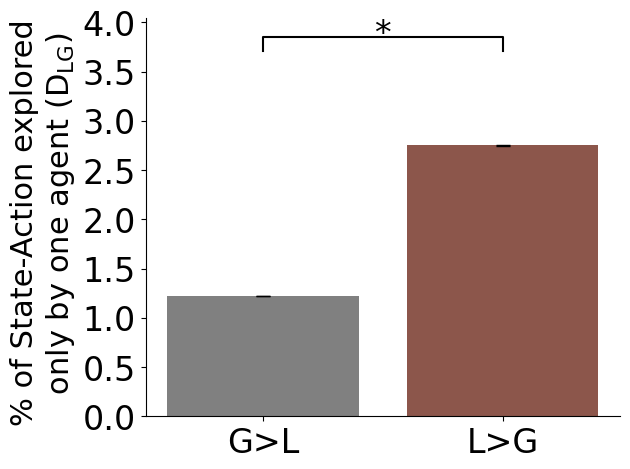

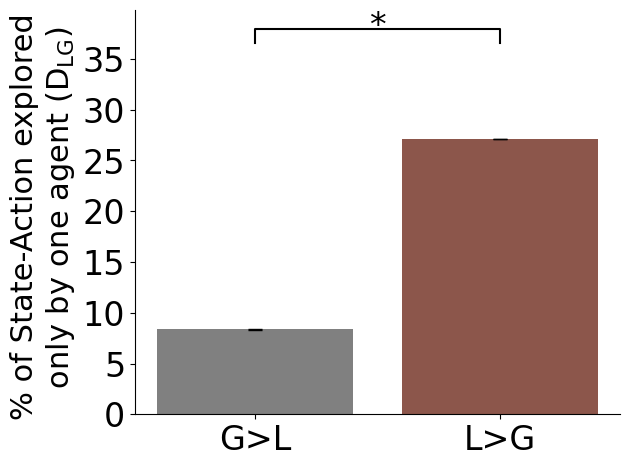

In [ ]:
plot_significant_bar(np.array(list(pong_means.values())), np.array(list(pong_sem.values())), '/content/pong_significance_bar.pdf')
plot_significant_bar(np.array(list(pacman_means.values())), np.array(list(pacman_sem.values())), '/content/pacman_significance_bar.pdf')

In [ ]:
import numpy as np
import seaborn as sns

values = scannet_accuracies
idx = archs
x = list(range(len(idx)))
W=0.8
clrs = ['grey' if (x < max(values)) else 'red' for x in values ]
palette = ['gray','black']
plt.ylabel('Accuracy',fontsize=24)
# plt.title('Generalization from synthetic to \n natural image data', fontsize=24)
plt.yticks(ticks = [0.1, 0.3, 0.5, 0.7, 0.9], labels = [0.1, 0.3, 0.5, 0.7, 0.9], fontsize=20)
plt.xticks(list(range(len(archs))),labels=archs,fontsize=10,rotation=45)
plt.bar(x, scannet_accuracies,width=W,color=palette,yerr=scannet_errors,capsize=5)

random_chance = 1/5
plt.axhline(y=random_chance, color='black', linestyle='--', label='Chance')

add_significance_bar(9,10, 0.72,0.01,'*')

sns.despine()
plt.tight_layout()
plt.savefig('paper_figures/generalization_to_scannet.pdf', bbox_inches='tight')




plt.show()
# sns.barplot(x=idx, y=values, palette=clrs)